# Exploratory Data Analysis on Indels (Fiber-seq & Element AVITI)

In [1]:
import io
import os
import csv
import numpy as np
import pandas as pd
import gzip as gz
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib_venn import venn2, venn3
from supervenn import supervenn # type: ignore
import sigProfilerPlotting as sigPlt
from SigProfilerAssignment import Analyzer as Analyze
from scipy.stats import fisher_exact
from scipy.stats import binomtest
from statsmodels.stats import multitest
from pathlib import Path
from tqdm import tqdm
import subprocess
from pyfaidx import Fasta

sns.set_theme(font="Arial", font_scale=1.15, style='ticks') 
matplotlib.rcParams['figure.dpi'] = 150
plt.rc("axes.spines", top=True, right=True)
%matplotlib inline

def read_vcf(path):
    if path[-3:] == ".gz": 
        with gz.open(path, 'rb') as f:
            lines = [l.decode('utf-8') for l in f if not l.startswith(b'##')]
            return pd.read_csv(
                io.StringIO(''.join(lines)),
                dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
                       'QUAL': str, 'FILTER': str, 'INFO': str},
                       sep='\t'
                       ).rename(columns={'#CHROM': 'CHROM'})
    else:
        with open(path, 'r') as f:
            lines = [l for l in f if not l.startswith('##')]
            return pd.read_csv(
                io.StringIO(''.join(lines)),
                dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
                       'QUAL': str, 'FILTER': str, 'INFO': str},
                       sep='\t'
                       ).rename(columns={'#CHROM': 'CHROM'})

def vcf_format_getter(df, field) -> pd.Series:
    """
    Parameters
    ----------
    
    df : pandas.core.frame.DataFrame
        vcf read through read_vcf()
    field : str
        GT, VAF, DP, AD
    
    return pd.Series

    Example vcf structure
    ----------
    FORMAT              COLO829T_PassageB_DSA  
    GT:GQ:DP:AD:VAF:PL  1/1:59:133:2,131:0.984962:65,60,0
    GT:GQ:DP:AD:VAF:PL  1/1:65:131:0,131:1:70,66,0
    GT:GQ:DP:AD:VAF:PL  1/1:53:49:0,49:1:58,54,0

    """
    sampleid = df.columns[9]
    format = list(set(df['FORMAT'].values))[0].split(':')

    if field == "GT":
        gtindex = format.index('GT')
        return df[sampleid].str.split(':').apply(lambda x: x[gtindex])
    
    elif field == "VAF":
        vafindex = format.index('VAF')
        return df[sampleid].str.split(':').apply(lambda x: float(x[vafindex]))
    
    elif field == "DP":
        dpindex = format.index('DP')
        return df[sampleid].str.split(':').apply(lambda x: int(x[dpindex]))
    
    elif field == "AD":
        adindex = format.index('AD')
        return df[sampleid].str.split(':').apply(lambda x: int(x[adindex].split(',')[1]))
    
    else:
        raise ValueError("field should be one of GT, VAF, DP and AD!")

def vcf_info_parser(info_string) -> dict:
    """
    Parameters
    ----------
    info_string : str
    SP=STK,RF,MT2,VN;RGN=Difficult;RGN_T=Tier2;VAF_Ill=0.965;VAF_PB=1

    return dict

    """
    return {i.split('=')[0]: i.split('=')[1] for i in info_string.split(';')}

def vcf_info_getter(df, field):
    """
    Parameters
    ----------
    
    df : pandas.core.frame.DataFrame
        vcf read through read_vcf()
    field : str
        VAF_Ill, VAF_PB
    
    return pd.Series

    Example vcf structure
    ----------
    INFO
    SP=STK,RF,MT2,VN;RGN=Difficult;RGN_T=Tier2;VAF_Ill=0.965;VAF_PB=1
    SP=STK,RF,MT2,VN;RGN=Easy;RGN_T=Tier0;VAF_Ill=0.981;VAF_PB=0.984
    """

    if field == "VAF_Ill" or field == "VAF_PB":
        return df['INFO'].apply(lambda x: float(vcf_info_parser(x)[field]) if vcf_info_parser(x)[field] != 'NA' else np.nan)

    else:
        return df['INFO'].apply(lambda x: vcf_info_parser(x).get(field))

def make_site_list(df: pd.DataFrame, path: str, prefix: str) -> None:
    """
    Parameters
    ----------
    df : pandas.core.frame.DataFrame 
        vcf read through read_vcf()
    path : str
        output path
    prefix : str
        f"{prefix}.sitelist"

    return target_list 
    """
    
    df = df[['CHROM', 'POS', 'POS']].drop_duplicates()
    
    df.to_csv(f"{os.path.join(path, prefix)}.sitelist", sep='\t', index=False, header=False)

def unix_wc(file: Path) -> int:
    wc = subprocess.run(['wc', '-l', str(file)], stdout=subprocess.PIPE)
    return int(wc.stdout.split()[0])

def get_fasta_sequence(fasta_file, chrom: str, start: int, end: int) -> str:
    fasta = Fasta(fasta_file)
    return fasta[chrom][start-1:end].seq

    #sequence = get_fasta_sequence(fasta_file, "haplotype1-0000001", 22573, 30000)

def count_stretches(sequence: str, nucleotide: str) -> int:
    c = 0
    window = len(nucleotide)
    
    # in PCAWG, max Repeat size is 5
    max_repeat = 5
    for i in range(max_repeat):
        subseq = sequence[window*i: window*(i+1)]
        if subseq == nucleotide:
            c += 1
        else:
            break
    return c

def get_microhomology(sequence: str, right_flank: str, left_flank: str) -> int:
    """
    :param sequence: deleted sequence from reference
    :param right_flank: right flanking sequence from deleted bases 
    :param left_flank: left flanking sequence from deletd bases
    """
    right_mh = 0
    left_mh = 0

    for i in range(len(sequence)-1):
        if sequence[i] == right_flank[i]:
            right_mh += 1
        else:
            break
    for j in range(1, len(sequence)):
        if sequence[-j] == left_flank[-j]:
            left_mh += 1
    
    # INFO: Sanity check
    if max(right_mh, left_mh) == 0:
        raise ValueError("Max(right homology, left homology) cannot be 0 in the code setting! Something's wrong")

    return min(max(right_mh, left_mh), 5)

def id83_generator(inputf: Path, outputf: Path, fasta_file: Path) -> dict:
    id83 = ['1:Del:C:0', '1:Del:C:1', '1:Del:C:2', '1:Del:C:3', '1:Del:C:4', '1:Del:C:5', '1:Del:T:0', '1:Del:T:1', '1:Del:T:2', '1:Del:T:3', '1:Del:T:4', '1:Del:T:5', '1:Ins:C:0', '1:Ins:C:1', '1:Ins:C:2', '1:Ins:C:3', '1:Ins:C:4', '1:Ins:C:5', '1:Ins:T:0', '1:Ins:T:1', '1:Ins:T:2', '1:Ins:T:3', '1:Ins:T:4', '1:Ins:T:5', '2:Del:R:0', '2:Del:R:1', '2:Del:R:2', '2:Del:R:3', '2:Del:R:4', '2:Del:R:5', '3:Del:R:0', '3:Del:R:1', '3:Del:R:2', '3:Del:R:3', '3:Del:R:4', '3:Del:R:5', '4:Del:R:0', '4:Del:R:1', '4:Del:R:2', '4:Del:R:3', '4:Del:R:4', '4:Del:R:5', '5:Del:R:0', '5:Del:R:1', '5:Del:R:2', '5:Del:R:3', '5:Del:R:4', '5:Del:R:5', '2:Ins:R:0', '2:Ins:R:1', '2:Ins:R:2', '2:Ins:R:3', '2:Ins:R:4', '2:Ins:R:5', '3:Ins:R:0', '3:Ins:R:1', '3:Ins:R:2', '3:Ins:R:3', '3:Ins:R:4', '3:Ins:R:5', '4:Ins:R:0', '4:Ins:R:1', '4:Ins:R:2', '4:Ins:R:3', '4:Ins:R:4', '4:Ins:R:5', '5:Ins:R:0', '5:Ins:R:1', '5:Ins:R:2', '5:Ins:R:3', '5:Ins:R:4', '5:Ins:R:5', '2:Del:M:1', '3:Del:M:1', '3:Del:M:2', '4:Del:M:1', '4:Del:M:2', '4:Del:M:3', '5:Del:M:1', '5:Del:M:2', '5:Del:M:3', '5:Del:M:4', '5:Del:M:5']
    id83_dict = dict.fromkeys(id83, 0)

    with open(inputf, 'r') as dfh, open(outputf, 'w', newline='') as rfh:

        wc = unix_wc(inputf)

        reader = csv.reader(dfh, delimiter='\t')
        writer = csv.writer(rfh, delimiter='\t')

        header = next(reader) # \tCHROM\tPOS\tID
        header.append('ID83')
        writer.writerow(header)

        CHROM_index = header.index("CHROM")
        POS_index = header.index("POS")
        REF_index = header.index("REF")
        ALT_index = header.index("ALT")
        INFO_index = header.index("INFO")
        FORMAT_index = header.index("FORMAT")

        for row in tqdm(reader, desc="Processing rows", total=wc-1):
            # INFO: check if the record is insertion or deletion
            refseq, altseq = row[REF_index], row[ALT_index]
            reflen, altlen = len(refseq), len(altseq)
            
            if reflen > altlen:
                deletion = True
                idseq = refseq[1:]
            else:
                deletion = False
                idseq = altseq[1:]
        
            idsize = abs(reflen - altlen)
            to_pyrimidine = {'A':'T', 'G':'C', 'T':'T', 'C':'C'}
            
            # INFO: Identifying the sequence context
            # NOTE: Deletion
            if deletion:
                if idsize == 1:
                    # BUG: idseq = to_pyrimidine[idseq]
                    seq_context = get_fasta_sequence(fasta_file, 
                                                     row[CHROM_index], 
                                                     int(row[POS_index]) + idsize + 1, 
                                                     int(row[POS_index]) + idsize + (idsize*5)
                                                     )
                    stretches = count_stretches(seq_context, idseq)
    
                    id83_category = f"{idsize}:Del:{to_pyrimidine[idseq]}:{stretches}"
                    #id83_dict[id83_category] += ad_getter(row, FORMAT_index)
                    id83_dict[id83_category] += 1
                    row.append(id83_category)
                    writer.writerow(row)
                else:
                    right_seq_context = get_fasta_sequence(fasta_file, 
                                                           row[CHROM_index],
                                                           int(row[POS_index]) + idsize + 1,
                                                           int(row[POS_index]) + idsize + (idsize*5)
                                                           )
                    right_stretches = count_stretches(right_seq_context, idseq)
                    
                    #NOTE: 1. Having repeat units 
                    if right_stretches != 0:
                        id83_category = f"{min(idsize, 5)}:Del:R:{right_stretches}"
                        #id83_dict[id83_category] += ad_getter(row, FORMAT_index)
                        id83_dict[id83_category] += 1
                        row.append(id83_category)
                        writer.writerow(row)
                    
                    else:
                        left_seq_context = get_fasta_sequence(fasta_file, 
                                                              row[CHROM_index],
                                                              int(row[POS_index]) - (idsize - 2),
                                                              int(row[POS_index])
                                                              )
                        
                        #BUG:check
                        if len(left_seq_context) + 1 != idsize:
                            print(idsize)
                            print(row)
                            print(right_seq_context)
                            print(left_seq_context)
                            raise ValueError("Something's wrong")

                        #NOTE: 2. No microhomology
                        if idseq[0] != right_seq_context[0] and idseq[-1] != left_seq_context[-1]:
                            id83_category = f"{min(idsize, 5)}:Del:R:0"
                            #id83_dict[id83_category] += ad_getter(row, FORMAT_index)
                            id83_dict[id83_category] += 1
                            row.append(id83_category)
                            writer.writerow(row)
                        #NOTE: 3. Microhomology (NOTE2 can be included in the NOTE3, for efficiency's sake)
                        else:
                            mh = get_microhomology(idseq, right_seq_context, left_seq_context)
                            id83_category = f"{min(idsize, 5)}:Del:M:{mh}"
                            #id83_dict[id83_category] += ad_getter(row, FORMAT_index)
                            id83_dict[id83_category] += 1
                            row.append(id83_category)
                            writer.writerow(row)
                            
            # NOTE: Insertion
            elif not deletion:
                if idsize == 1:
                    # BUG: idseq = to_pyrimidine[idseq]
                    seq_context = get_fasta_sequence(fasta_file, 
                                                     row[CHROM_index], 
                                                     int(row[POS_index]) + 1, 
                                                     int(row[POS_index]) + (idsize*5)
                                                     )
                    stretches = count_stretches(seq_context, idseq)

                    id83_category = f"{idsize}:Ins:{to_pyrimidine[idseq]}:{stretches}"
                    #id83_dict[id83_category] += ad_getter(row, FORMAT_index)
                    id83_dict[id83_category] += 1
                    row.append(id83_category)
                    writer.writerow(row)

                else:
                    seq_context = get_fasta_sequence(fasta_file, 
                                                     row[CHROM_index],
                                                     int(row[POS_index]) + 1,
                                                     int(row[POS_index]) + (idsize*5)
                                                     )
                    stretches = count_stretches(seq_context, idseq)

                    id83_category = f"{min(idsize, 5)}:Ins:R:{stretches}"
                    #id83_dict[id83_category] += ad_getter(row, FORMAT_index)
                    id83_dict[id83_category] += 1
                    row.append(id83_category)
                    writer.writerow(row)

            rfh.flush() # Let's delete this once writing the program is finished
    return id83_dict


dir_fiberseq="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.8.0"
dir_element="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Element/VariantCalls_DeepVariant_1.6.1"

DSA="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/DSA/DSA_COLO829BL_v3.0.0.fasta"

colobl_fiberseq_vcf = read_vcf(f"{dir_fiberseq}/COLO829BL/deepvariant/COLO829BL.deepvariant.PASS.indel.annot.vcf.gz")
colotb_fiberseq_vcf = read_vcf(f"{dir_fiberseq}/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.vcf.gz")
colota_fiberseq_vcf = read_vcf(f"{dir_fiberseq}/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.PASS.indel.annot.vcf.gz")
colobl_element_vcf = read_vcf(f"{dir_element}/COLO829BL_Element_DSA/deepvariant/COLO829BL_Element_DSA.deepvariant.PASS.indel.annot.vcf.gz")
colotb_element_vcf = read_vcf(f"{dir_element}/COLO829T_Element_DSA/deepvariant/COLO829T_Element_DSA.deepvariant.PASS.indel.annot.vcf.gz")

colobl_fiberseq_vcf['INDELid'] = colobl_fiberseq_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
colotb_fiberseq_vcf['INDELid'] = colotb_fiberseq_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
colota_fiberseq_vcf['INDELid'] = colota_fiberseq_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
colobl_element_vcf['INDELid'] = colobl_element_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
colotb_element_vcf['INDELid'] = colotb_element_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)

/mmfs1/gscratch/stergachislab/mhsohny/Miniconda/envs/sigprofiler/lib/python3.11/site-packages/supervenn/_utils.py:69: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  row_iterator = flags.iteritems()  # deprecated since pandas 1.5
/mmfs1/gscratch/stergachislab/mhsohny/Miniconda/envs/sigprofiler/lib/python3.11/site-packages/supervenn/_utils.py:69: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  row_iterator = flags.iteritems()  # deprecated since pandas 1.5


In [2]:
colobl_fiberseq_indels_correct = colobl_fiberseq_vcf[(vcf_info_getter(colobl_fiberseq_vcf, "Flagger") == "Hap") & (vcf_info_getter(colobl_fiberseq_vcf, "NucFlag").isna())]
colotb_fiberseq_indels_correct = colotb_fiberseq_vcf[(vcf_info_getter(colotb_fiberseq_vcf, "Flagger") == "Hap") & (vcf_info_getter(colotb_fiberseq_vcf, "NucFlag").isna())]
colota_fiberseq_indels_correct = colota_fiberseq_vcf[(vcf_info_getter(colota_fiberseq_vcf, "Flagger") == "Hap") & (vcf_info_getter(colota_fiberseq_vcf, "NucFlag").isna())]
colobl_element_indels_correct = colobl_element_vcf[(vcf_info_getter(colobl_element_vcf, "Flagger") == "Hap") & (vcf_info_getter(colobl_element_vcf, "NucFlag").isna())]
colotb_element_indels_correct = colotb_element_vcf[(vcf_info_getter(colotb_element_vcf, "Flagger") == "Hap") & (vcf_info_getter(colotb_element_vcf, "NucFlag").isna())]

Text(0, 0.5, 'Samples')

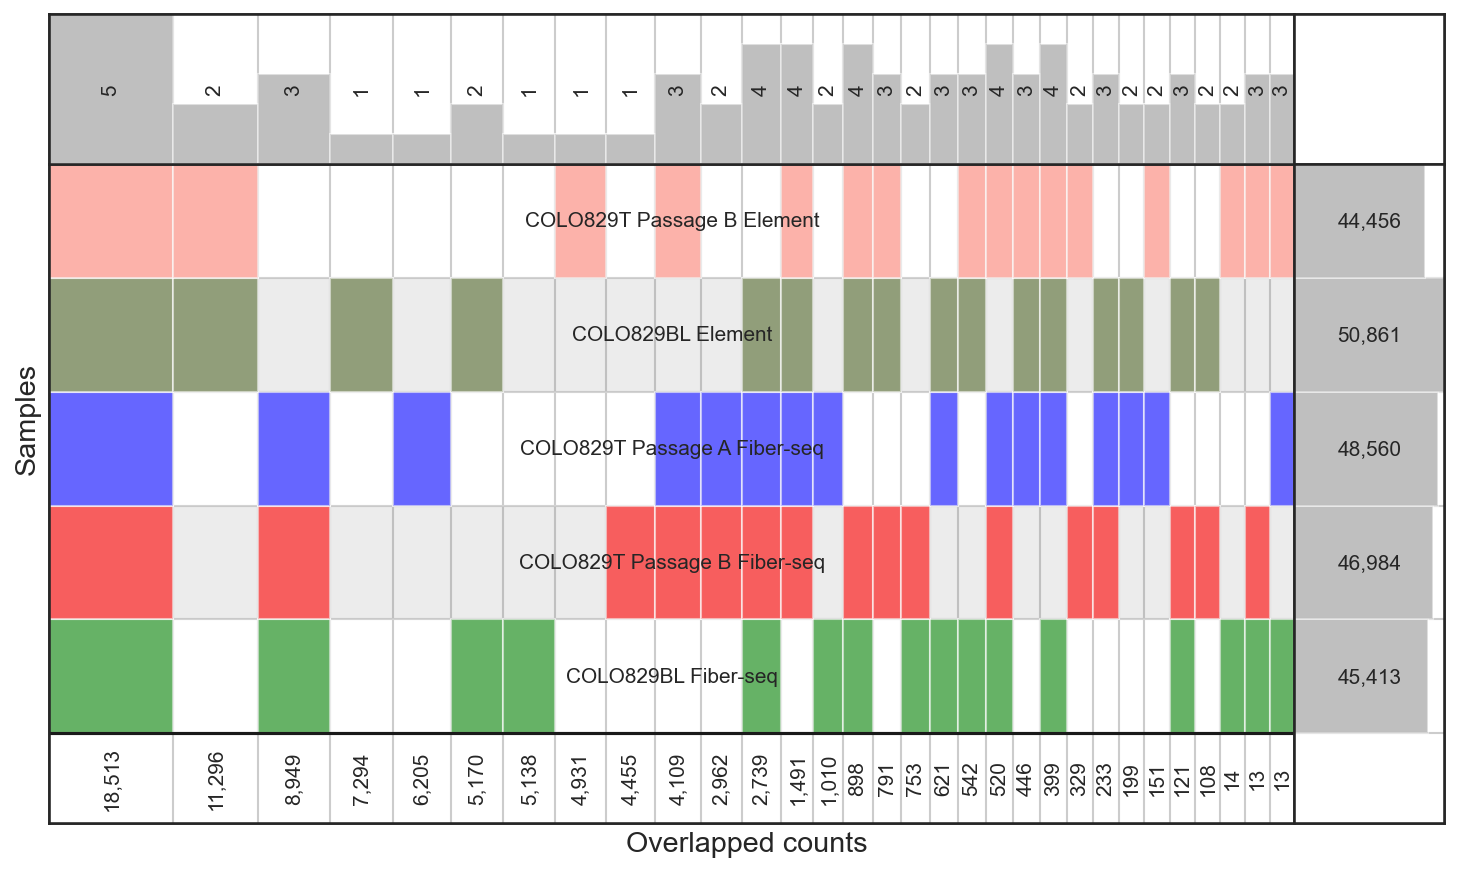

In [3]:
colobl_fiberseq_indels_correct_set: set[str] = set(colobl_fiberseq_indels_correct['INDELid'].values)
colotb_fiberseq_indels_correct_set: set[str] = set(colotb_fiberseq_indels_correct['INDELid'].values)
colota_fiberseq_indels_correct_set: set[str] = set(colota_fiberseq_indels_correct['INDELid'].values)

colobl_element_indels_correct_set: set[str] = set(colobl_element_indels_correct['INDELid'].values)
colotb_element_indels_correct_set: set[str] = set(colotb_element_indels_correct['INDELid'].values)

fig, ax = plt.subplots(1,1, figsize=(12,7), constrained_layout=False)
sets: list[set] = [colobl_fiberseq_indels_correct_set, colotb_fiberseq_indels_correct_set, colota_fiberseq_indels_correct_set, colobl_element_indels_correct_set, colotb_element_indels_correct_set]
labels: list[str] = ['COLO829BL Fiber-seq', 'COLO829T Passage B Fiber-seq', 'COLO829T Passage A Fiber-seq', 'COLO829BL Element', 'COLO829T Passage B Element']

supervenn(sets, 
          labels, 
          color_cycle=['green', 'red', 'blue', 'darkolivegreen', 'salmon'],
          widths_minmax_ratio=0.2,
          sets_ordering=None,
          chunks_ordering='size',
          col_annotations_area_height=1.1,
          rotate_col_annotations=True,
          side_plots=True,
          fontsize=10, 
          ax=ax)

ax.set_xlabel("Overlapped counts")
ax.set_ylabel("Samples")

In [17]:
#4_931 + 4_109 + 520 + 329 + 151 + 14 + 13 + 13
4_109 + 2_962 + 1_491 + 233

8795

In [41]:
"""
colotb_fiberseq_indels_pass_annot_hap.to_csv(f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA.tsv", sep="\t")
colobl_fiberseq_indels_pass_annot_hap.to_csv(f"{dir_fiberseq}/03.ID/COLO829BL_DSA.tsv", sep="\t")
colota_fiberseq_indels_pass_annot_hap.to_csv(f"{dir_fiberseq}/03.ID/COLO829T_PassageA_DSA.tsv", sep="\t")

colotb_element_indels_pass_annot_hap.to_csv(f"{dir_element}/03.ID/COLO829T_Element_DSA.tsv", sep="\t")
colobl_element_indels_pass_annot_hap.to_csv(f"{dir_element}/03.ID/COLO829BL_Element_DSA.tsv", sep="\t")
"""

'\ncolotb_fiberseq_indels_pass_annot_hap.to_csv(f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA.tsv", sep="\t")\ncolobl_fiberseq_indels_pass_annot_hap.to_csv(f"{dir_fiberseq}/03.ID/COLO829BL_DSA.tsv", sep="\t")\ncolota_fiberseq_indels_pass_annot_hap.to_csv(f"{dir_fiberseq}/03.ID/COLO829T_PassageA_DSA.tsv", sep="\t")\n\ncolotb_element_indels_pass_annot_hap.to_csv(f"{dir_element}/03.ID/COLO829T_Element_DSA.tsv", sep="\t")\ncolobl_element_indels_pass_annot_hap.to_csv(f"{dir_element}/03.ID/COLO829BL_Element_DSA.tsv", sep="\t")\n'

In [ ]:
ulconsv_set = (colotb_element_indels_correct_set & colotb_fiberseq_indels_correct_set & colota_fiberseq_indels_correct_set) - colobl_fiberseq_indels_correct_set - colobl_element_indels_correct_set
colotb_fiberseq_indels_correct_ulconsv = colotb_fiberseq_indels_correct[colotb_fiberseq_indels_correct['INDELid'].isin(ulconsv_set)].reset_index(drop=True)

fb_set = (colotb_fiberseq_indels_correct_set & colota_fiberseq_indels_correct_set) - colobl_fiberseq_indels_correct_set - colobl_element_indels_correct_set - colotb_element_indels_correct_set
colotb_fiberseq_indels_correct_fbonly = colotb_fiberseq_indels_correct[colotb_fiberseq_indels_correct['INDELid'].isin(fb_set)].reset_index(drop=True)

element_set = (colotb_element_indels_correct_set - colobl_element_indels_correct_set) - colobl_fiberseq_indels_correct_set - colotb_fiberseq_indels_correct_set - colota_fiberseq_indels_correct_set
colotb_element_indels_correct_elonly = colotb_element_indels_correct[colotb_element_indels_correct['INDELid'].isin(element_set)].reset_index(drop=True)

colotb_fiberseq_indels_correct_fbonly = colotb_fiberseq_indels_correct[colotb_fiberseq_indels_correct['INDELid'].isin(fb_set)].reset_index(drop=True)

In [27]:
colotb_fiberseq_indels_correct_fbonly.head(n=40)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,COLO829T_PassageB_DSA,INDELid
0,haplotype1-0000001,4244339,.,G,GTATA,28.1,PASS,Flagger=Hap;RM=Simple_repeat/unknown;TRF=trf_1...,GT:GQ:DP:AD:VAF:PL,"0/1:8:118:56,53:0.449153:27,26,7",haplotype1-0000001_4244339_G_GTATA
1,haplotype1-0000001,4620155,.,CA,C,46.2,PASS,Flagger=Hap;RM=SINE/Alu,GT:GQ:DP:AD:VAF:PL,"1/1:38:109:15,76:0.697248:46,38,0",haplotype1-0000001_4620155_CA_C
2,haplotype1-0000001,6464682,.,C,CAT,23,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"1/1:21:146:47,87:0.59589:22,26,0",haplotype1-0000001_6464682_C_CAT
3,haplotype1-0000001,13694496,.,G,GTCTT,24.9,PASS,Flagger=Hap;RM=Simple_repeat/unknown;TRF=trf_5...,GT:GQ:DP:AD:VAF:PL,"1/1:21:69:28,33:0.478261:24,22,0",haplotype1-0000001_13694496_G_GTCTT
4,haplotype1-0000001,14169187,.,GA,G,34.7,PASS,Flagger=Hap;RM=Simple_repeat/unknown,GT:GQ:DP:AD:VAF:PL,"0/1:33:124:48,51:0.41129:34,0,39",haplotype1-0000001_14169187_GA_G
5,haplotype1-0000001,18421342,.,T,TA,27.5,PASS,Flagger=Hap;RM=SINE/Alu;TRF=trf_7213/1.9/171/8...,GT:GQ:DP:AD:VAF:PL,"1/1:20:107:37,42:0.392523:27,20,0",haplotype1-0000001_18421342_T_TA
6,haplotype1-0000001,18701201,.,C,CT,20.3,PASS,Flagger=Hap;TRF=trf_7302/37.0/1/83/0.53,GT:GQ:DP:AD:VAF:PL,"1/1:18:103:30,42:0.407767:20,20,0",haplotype1-0000001_18701201_C_CT
7,haplotype1-0000001,21317291,.,C,CT,5.4,PASS,Flagger=Hap;RM=SINE/Alu;TRF=trf_8370/31.0/1/93...,GT:GQ:DP:AD:VAF:PL,"1/1:4:107:44,28:0.261682:3,9,0",haplotype1-0000001_21317291_C_CT
8,haplotype1-0000001,22996105,.,C,CA,66.3,PASS,Flagger=Hap;RM=SINE/Alu,GT:GQ:DP:AD:VAF:MID:PL,"1/1:39:76:16,51:0.671053:small_model:66,38,0",haplotype1-0000001_22996105_C_CA
9,haplotype1-0000001,23535044,.,A,ATT,27.3,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"0/1:3:79:52,15:0.189873:24,22,19",haplotype1-0000001_23535044_A_ATT


In [11]:
colotb_element_indels_correct_elonly.head(n=40)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,COLO829T_Element_DSA,INDELid
0,haplotype1-0000001,4625005,.,AT,A,26.2,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"0/1:26:44:32,11:0.25:26,0,41",haplotype1-0000001_4625005_AT_A
1,haplotype1-0000001,4877991,.,CA,C,28,PASS,Flagger=Hap;RM=SINE/Alu,GT:GQ:DP:AD:VAF:PL,"0/1:27:36:14,22:0.611111:28,0,32",haplotype1-0000001_4877991_CA_C
2,haplotype1-0000001,5614637,.,GA,G,5,PASS,Flagger=Hap;RM=Simple_repeat/unknown;FIRE=peak...,GT:GQ:DP:AD:VAF:PL,"0/1:5:64:42,22:0.34375:3,0,22",haplotype1-0000001_5614637_GA_G
3,haplotype1-0000001,8676839,.,CT,C,12.7,PASS,Flagger=Hap;RM=SINE/Alu,GT:GQ:DP:AD:VAF:PL,"0/1:13:31:23,8:0.258065:12,0,37",haplotype1-0000001_8676839_CT_C
4,haplotype1-0000001,8682771,.,A,AT,39.3,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"0/1:39:34:12,22:0.647059:39,0,48",haplotype1-0000001_8682771_A_AT
5,haplotype1-0000001,10747191,.,AC,A,7.1,PASS,Flagger=Hap;RM=SINE/Alu;TRF=trf_4048/5.3/7/90/...,GT:GQ:DP:AD:VAF:PL,"0/1:7:65:50,13:0.2:6,0,32",haplotype1-0000001_10747191_AC_A
6,haplotype1-0000001,11634574,.,CT,C,8.3,PASS,Flagger=Hap;RM=SINE/Alu,GT:GQ:DP:AD:VAF:PL,"0/1:8:78:44,34:0.435897:7,0,22",haplotype1-0000001_11634574_CT_C
7,haplotype1-0000001,14887080,.,C,CTG,29.3,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"0/1:29:32:17,15:0.46875:29,0,42",haplotype1-0000001_14887080_C_CTG
8,haplotype1-0000001,15202679,.,CT,C,28.6,PASS,Flagger=Hap;RM=SINE/Alu;TRF=trf_5981/2.1/16/94...,GT:GQ:DP:AD:VAF:PL,"0/1:28:49:30,19:0.387755:28,0,44",haplotype1-0000001_15202679_CT_C
9,haplotype1-0000001,19176423,.,C,CA,30.3,PASS,Flagger=Hap;RM=SINE/Alu,GT:GQ:DP:AD:VAF:PL,"1/1:29:23:0,22:0.956522:30,33,0",haplotype1-0000001_19176423_C_CA


In [22]:
os.system(f"mkdir -p {dir_fiberseq}/03.ID/Ultraconservative")
colotb_fiberseq_indels_correct_ulconsv.to_csv(f"{dir_fiberseq}/03.ID/Ultraconservative/COLO829T_PassageB_DSA_ultraconservative.tsv", sep="\t")
colotb_fiberseq_indels_correct_ulconsv_id83_dict = id83_generator(f"{dir_fiberseq}/03.ID/Ultraconservative/COLO829T_PassageB_DSA_ultraconservative.tsv", f"{dir_fiberseq}/03.ID/Ultraconservative/COLO829T_PassageB_DSA_ultraconservative_ID83.tsv", f"{DSA}")
pd.DataFrame(colotb_fiberseq_indels_correct_ulconsv_id83_dict.items(), columns=['MutationType', 'COLO829TB']).to_csv(f"{dir_fiberseq}/03.ID/Ultraconservative/COLO829T_PassageB_DSA_ultraconservative_ID83_SigProfiler_Input.tsv", sep='\t', index=False)

sigPlt.plotID(matrix_path=f"{dir_fiberseq}/03.ID/Ultraconservative/COLO829T_PassageB_DSA_ultraconservative_ID83_SigProfiler_Input.tsv", 
              output_path=f"{dir_fiberseq}/03.ID/Ultraconservative", 
              project="COLO829T_PassageB_DSA_ultraconservative", 
              plot_type="83", 
              savefig_format="pdf",
              percentage=False)

sigPlt.plotID(matrix_path=f"{dir_fiberseq}/03.ID/Ultraconservative/COLO829T_PassageB_DSA_ultraconservative_ID83_SigProfiler_Input.tsv", 
              output_path=f"{dir_fiberseq}/03.ID/Ultraconservative", 
              project="COLO829T_PassageB_DSA_ultraconservative_Percentage", 
              plot_type="83", 
              savefig_format="pdf",
              percentage=True)

Analyze.cosmic_fit(
    f"{dir_fiberseq}/03.ID/Ultraconservative/COLO829T_PassageB_DSA_ultraconservative_ID83_SigProfiler_Input.tsv", 
    f"{dir_fiberseq}/03.ID/Ultraconservative", 
    input_type="matrix", 
    context_type="83", 
    collapse_to_SBS96=False, 
    cosmic_version=3.4, 
    exome=False,
    genome_build="GRCh38", 
    signature_database=None,
    exclude_signature_subgroups=None, 
    export_probabilities=True,
    export_probabilities_per_mutation=False, 
    make_plots=True,
    sample_reconstruction_plots="pdf", 
    verbose=False)

Processing rows:   0%|          | 0/4109 [00:00<?, ?it/s]

Processing rows: 100%|██████████| 4109/4109 [01:04<00:00, 63.49it/s] 


Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 1/1 [100%] in 0.1s (19.90/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


In [44]:
"""
colotb_fiberseq_indels_pass_annot_hap_fiberseqonly.to_csv(f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly.tsv", sep="\t")
colotb_fiberseq_indels_pass_annot_hap_fiberseqonly_id83_dict = id83_generator(f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly.tsv", f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly_ID83.tsv")
pd.DataFrame(colotb_fiberseq_indels_pass_annot_hap_fiberseqonly_id83_dict.items(), columns=['MutationType', 'COLO829TB']).to_csv(f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly_ID83_SigProfiler_Input.tsv", sep='\t', index=False)

import sigProfilerPlotting as sigPlt
from SigProfilerAssignment import Analyzer as Analyze

sigPlt.plotID(matrix_path=f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly_ID83_SigProfiler_Input.tsv", 
              output_path=f"{dir_fiberseq}/03.ID", 
              project="COLO829T_PassageB_DSA_fiberseqonly", 
              plot_type="83", 
              savefig_format="pdf",
              percentage=False)

sigPlt.plotID(matrix_path=f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly_ID83_SigProfiler_Input.tsv", 
              output_path=f"{dir_fiberseq}/03.ID", 
              project="COLO829T_PassageB_DSA_fiberseqonly_Percentage", 
              plot_type="83", 
              savefig_format="pdf",
              percentage=True)

Analyze.cosmic_fit(
    f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly_ID83_SigProfiler_Input.tsv", 
    f"{dir_fiberseq}/03.ID", 
    input_type="matrix", 
    context_type="83", 
    collapse_to_SBS96=False, 
    cosmic_version=3.4, 
    exome=False,
    genome_build="GRCh38", 
    signature_database=None,
    exclude_signature_subgroups=None, 
    export_probabilities=True,
    export_probabilities_per_mutation=False, 
    make_plots=True,
    sample_reconstruction_plots="pdf", 
    verbose=False)
"""

'\ncolotb_fiberseq_indels_pass_annot_hap_fiberseqonly.to_csv(f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly.tsv", sep="\t")\ncolotb_fiberseq_indels_pass_annot_hap_fiberseqonly_id83_dict = id83_generator(f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly.tsv", f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly_ID83.tsv")\npd.DataFrame(colotb_fiberseq_indels_pass_annot_hap_fiberseqonly_id83_dict.items(), columns=[\'MutationType\', \'COLO829TB\']).to_csv(f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly_ID83_SigProfiler_Input.tsv", sep=\'\t\', index=False)\n\nimport sigProfilerPlotting as sigPlt\nfrom SigProfilerAssignment import Analyzer as Analyze\n\nsigPlt.plotID(matrix_path=f"{dir_fiberseq}/03.ID/COLO829T_PassageB_DSA_fiberseqonly_ID83_SigProfiler_Input.tsv", \n              output_path=f"{dir_fiberseq}/03.ID", \n              project="COLO829T_PassageB_DSA_fiberseqonly", \n              plot_type="83", \n              savefig_format="pdf",\n          

In [45]:
"""
colotb_element_indels_pass_annot_hap_elementonly.to_csv(f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly.tsv", sep="\t")
colotb_element_indels_pass_annot_hap_elementonly_id83_dict = id83_generator(f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly.tsv", f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly_ID83.tsv")
pd.DataFrame(colotb_element_indels_pass_annot_hap_elementonly_id83_dict.items(), columns=['MutationType', 'COLO829TB']).to_csv(f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly_ID83_SigProfiler_Input.tsv", sep='\t', index=False)

sigPlt.plotID(matrix_path=f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly_ID83_SigProfiler_Input.tsv", 
              output_path=f"{dir_element}/03.ID", 
              project="COLO829T_Element_DSA_elementonly", 
              plot_type="83", 
              savefig_format="pdf",
              percentage=False)

sigPlt.plotID(matrix_path=f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly_ID83_SigProfiler_Input.tsv", 
              output_path=f"{dir_element}/03.ID", 
              project="COLO829T_Element_DSA_elementonly_Percentage", 
              plot_type="83", 
              savefig_format="pdf",
              percentage=True)

Analyze.cosmic_fit(
    f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly_ID83_SigProfiler_Input.tsv", 
    f"{dir_element}/03.ID", 
    input_type="matrix", 
    context_type="83", 
    collapse_to_SBS96=False, 
    cosmic_version=3.4, 
    exome=False,
    genome_build="GRCh38", 
    signature_database=None,
    exclude_signature_subgroups=None, 
    export_probabilities=True,
    export_probabilities_per_mutation=False, 
    make_plots=True,
    sample_reconstruction_plots="pdf", 
    verbose=False)
"""

'\ncolotb_element_indels_pass_annot_hap_elementonly.to_csv(f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly.tsv", sep="\t")\ncolotb_element_indels_pass_annot_hap_elementonly_id83_dict = id83_generator(f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly.tsv", f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly_ID83.tsv")\npd.DataFrame(colotb_element_indels_pass_annot_hap_elementonly_id83_dict.items(), columns=[\'MutationType\', \'COLO829TB\']).to_csv(f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly_ID83_SigProfiler_Input.tsv", sep=\'\t\', index=False)\n\nsigPlt.plotID(matrix_path=f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly_ID83_SigProfiler_Input.tsv", \n              output_path=f"{dir_element}/03.ID", \n              project="COLO829T_Element_DSA_elementonly", \n              plot_type="83", \n              savefig_format="pdf",\n              percentage=False)\n\nsigPlt.plotID(matrix_path=f"{dir_element}/03.ID/COLO829T_Element_DSA_elementonly_ID83_SigProfi

In [5]:
colotb_fiberseq_indels_correct_ulconsv

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,COLO829T_PassageB_DSA,INDELid
0,haplotype1-0000001,4708702,.,C,CGT,27.1,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"0/1:27:129:71,42:0.325581:27,0,39",haplotype1-0000001_4708702_C_CGT
1,haplotype1-0000001,6230255,.,AT,A,99,PASS,Flagger=Hap;RM=LINE/L1,GT:GQ:DP:AD:VAF:MID:PL,"1/1:99:137:6,123:0.89781:small_model:99,75,0",haplotype1-0000001_6230255_AT_A
2,haplotype1-0000001,7439493,.,GA,G,38,PASS,Flagger=Hap;RM=LINE/L1,GT:GQ:DP:AD:VAF:PL,"0/1:38:125:53,68:0.544:37,0,49",haplotype1-0000001_7439493_GA_G
3,haplotype1-0000001,8232382,.,A,AACAC,29,PASS,Flagger=Hap,GT:GQ:DP:AD:VAF:PL,"1/1:27:101:13,57:0.564356:28,30,0",haplotype1-0000001_8232382_A_AACAC
4,haplotype1-0000001,8316016,.,CA,C,54.9,PASS,Flagger=Hap;RM=SINE/Alu,GT:GQ:DP:AD:VAF:PL,"1/1:50:128:11,94:0.734375:54,52,0",haplotype1-0000001_8316016_CA_C
...,...,...,...,...,...,...,...,...,...,...,...
4104,haplotype2-0000079,162860502,.,C,CA,49.3,PASS,Flagger=Hap;RM=SINE/Alu,GT:GQ:DP:AD:VAF:PL,"1/1:36:59:16,36:0.610169:49,35,0",haplotype2-0000079_162860502_C_CA
4105,haplotype2-0000079,163076986,.,TA,T,51.3,PASS,Flagger=Hap;RM=LINE/L1,GT:GQ:DP:AD:VAF:PL,"1/1:32:56:8,36:0.642857:51,31,0",haplotype2-0000079_163076986_TA_T
4106,haplotype2-0000079,163113894,.,CA,C,17.9,PASS,Flagger=Hap;RM=Low_complexity/unknown,GT:GQ:DP:AD:VAF:PL,"1/1:16:66:15,28:0.424242:17,21,0",haplotype2-0000079_163113894_CA_C
4107,haplotype2-0000079,163480530,.,C,CA,34.4,PASS,Flagger=Hap;RM=Simple_repeat/unknown,GT:GQ:DP:AD:VAF:PL,"1/1:21:52:25,19:0.365385:34,21,0",haplotype2-0000079_163480530_C_CA


<Axes: xlabel='COLO829T_PassageB_DSA', ylabel='Count'>

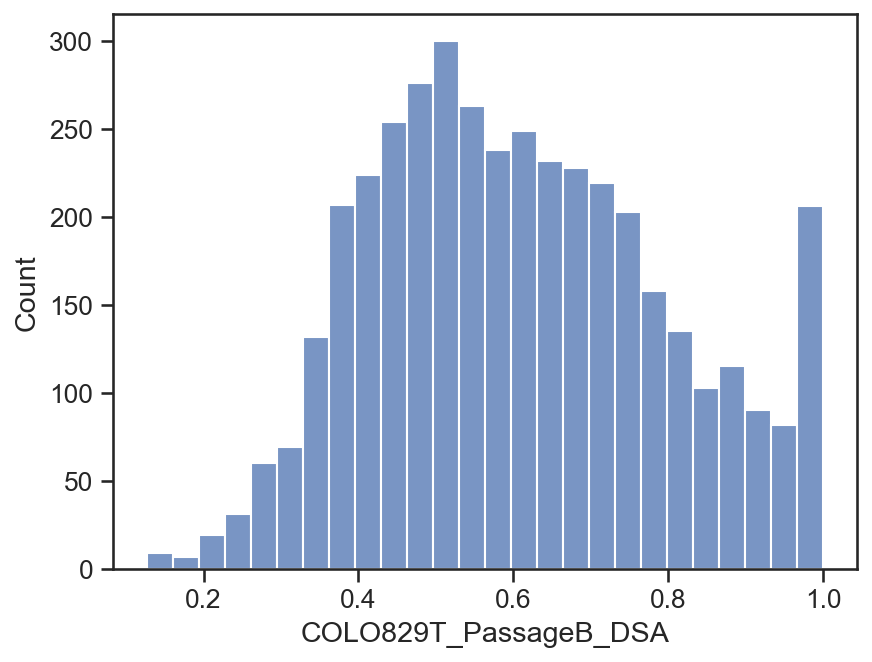

In [21]:
sns.histplot(vcf_format_getter(colotb_fiberseq_indels_correct_ulconsv, "VAF"))

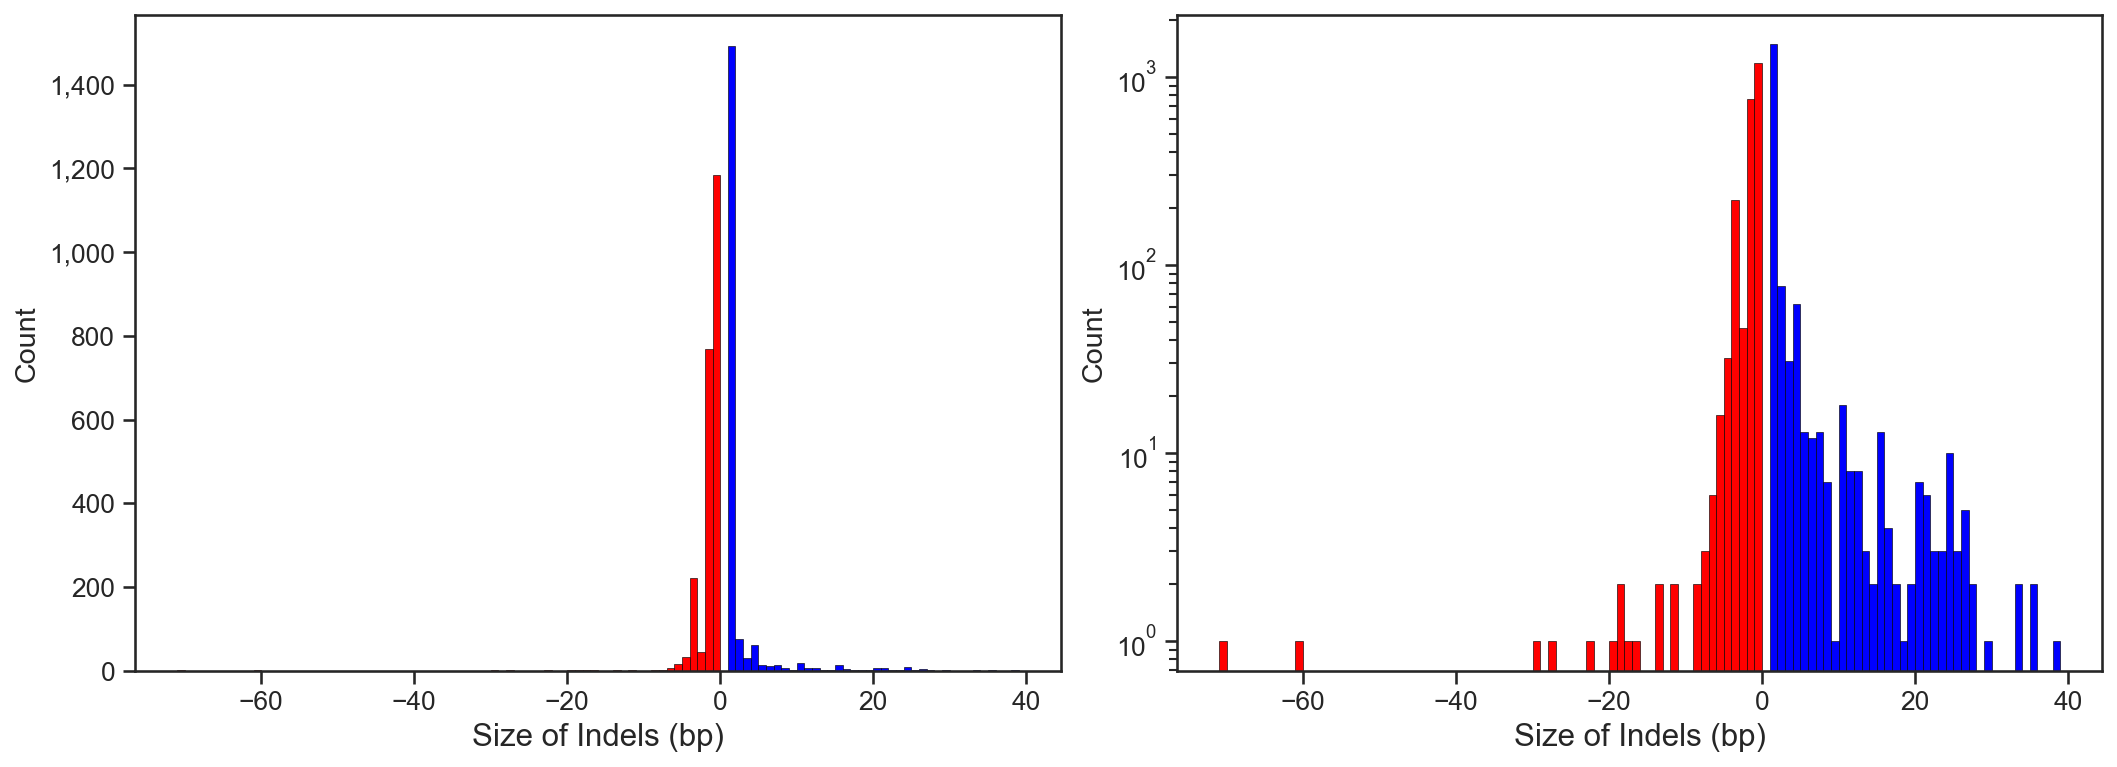

In [6]:
colotb_fiberseq_indels_correct_ulconsv_indel_length = colotb_fiberseq_indels_correct_ulconsv["REF"].str.len() - colotb_fiberseq_indels_correct_ulconsv["ALT"].str.len()

fig, axes = plt.subplots(1,2, figsize=(14,5), constrained_layout=True)
sns.histplot(data=colotb_fiberseq_indels_correct_ulconsv_indel_length, 
             bins=range(min(colotb_fiberseq_indels_correct_ulconsv_indel_length), max(colotb_fiberseq_indels_correct_ulconsv_indel_length) + 2),
             edgecolor='black',
             ax=axes[0])

patches0 = axes[0].patches

for patch in patches0:
    if patch.get_x() > 0:
        patch.set_facecolor('blue')
    else:
        patch.set_facecolor('red')

axes[0].set_xlabel("Size of Indels (bp)", fontsize=15)
axes[0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.histplot(data=colotb_fiberseq_indels_correct_ulconsv_indel_length, 
             bins=range(min(colotb_fiberseq_indels_correct_ulconsv_indel_length), max(colotb_fiberseq_indels_correct_ulconsv_indel_length) + 2),
             edgecolor='black',
             ax=axes[1])

patches1 = axes[1].patches

for patch in patches1:
    if patch.get_x() > 0:
        patch.set_facecolor('blue')
    else:
        patch.set_facecolor('red')

axes[1].set_xlabel("Size of Indels (bp)", fontsize=15)
axes[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[1].set_yscale('log')

## Make Pileup Sitelist for each set of indels

In [ ]:
# Ultraconservative
make_site_list(colotb_fiberseq_indels_correct_ulconsv,
               f"{dir_fiberseq}/03.ID",
               "COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.ultraconservative")

# Fiber-seq Only
make_site_list(colotb_fiberseq_indels_correct_fbonly,
               f"{dir_fiberseq}/03.ID",
               "COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.fiberseqonly")

# Element Only
make_site_list(colotb_element_indels_correct_elonly,
               f"{dir_element}/03.ID",
               "COLO829T_Element_DSA.deepvariant.PASS.indel.annot.elementonly")

In [16]:
print(f"# of FIRE elements overlapped with Ultraconservative indels: {len(set(vcf_info_getter(colotb_fiberseq_indels_correct_ulconsv, 'FIRE').dropna().values))}")
print(f"# of FIRE elements overlapped with Fiber-seq only indels: {len(set(vcf_info_getter(colotb_fiberseq_indels_correct_fbonly, 'FIRE').dropna().values))}")
print(f"# of FIRE elements overlapped with Element only indels: {len(set(vcf_info_getter(colotb_element_indels_correct_elonly, 'FIRE').dropna().values))}")

# of FIRE elements overlapped with Ultraconservative indels: 42
# of FIRE elements overlapped with Fiber-seq only indels: 84
# of FIRE elements overlapped with Element only indels: 52


## With Ultra-conservative Indel set 

### Fisher's Exact test-based Filtering

In [9]:
merged_ultraconservative_vcf = read_vcf(f"{dir_fiberseq}/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.ultraconservative.mpileup.indel.reheader.vcf.gz")
merged_ultraconservative_vcf['INDELid'] = merged_ultraconservative_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)

merged_ultraconservative_vcf[merged_ultraconservative_vcf['INDELid'].isin(ulconsv_set)][["CHROM", "POS", "REF", "ALT", "COLO829BL_Element", "COLO829T_Element", "COLO829BL_Fiber-seq", "COLO829T_PassageB_DSA", "COLO829T_PassageA_DSA", "INDELid"]].reset_index(drop=True).to_csv(f"{dir_fiberseq}/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.ultraconservative.mpileup.indel.reheader.tsv", sep="\t", index=None)

In [ ]:
from scipy.stats import fisher_exact
with open(f"{dir_fiberseq}/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.ultraconservative.mpileup.indel.reheader.tsv", 'r') as dfh, open(f"{dir_fiberseq}/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.ultraconservative.mpileup.indel.reheader_fisher.tsv", 'w') as rfh: 
    header = dfh.readline().strip()
    rfh.write(header + '\t' + 'pvalueTB' + '\t' + 'pvalueTA' + '\n')
    # 4: error rate of Element
    # 5: VAFsomatic of Element T
    # 6: error rate of BL
    # 7: VAFsomatic of TB
    # 8: VAFsomatic of TA
    # 9: indel ID
    for i in dfh:
        line = i.strip().split('\t')

        element_bl = list(map(lambda x: int(x), line[4].split(':')[-1].split(',')))
        if element_bl[1] == 0: # There should be zero alternative read coverage for Element COLO829BL
            fiberseq_bl = list(map(lambda x: int(x), line[6].split(':')[-1].split(',')))
            fiberseq_tb = list(map(lambda x: int(x), line[7].split(':')[-1].split(',')))
            fiberseq_ta = list(map(lambda x: int(x), line[8].split(':')[-1].split(',')))

            tb_table = [[fiberseq_tb[1], fiberseq_tb[0]],
                        [fiberseq_bl[1], fiberseq_bl[0]]]

            ta_table = [[fiberseq_ta[1], fiberseq_ta[0]],
                        [fiberseq_bl[1], fiberseq_bl[0]]]

            tb_fisher = fisher_exact(tb_table, alternative='greater')
            
            ta_fisher = fisher_exact(ta_table, alternative='greater')

            rfh.write('\t'.join(line) + '\t' + f"{tb_fisher.pvalue}\t{ta_fisher.pvalue}\n")

In [8]:
fisher = pd.read_table(f"{dir_fiberseq}/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.ultraconservative.mpileup.indel.reheader_fisher.tsv", sep="\t")

pvalues = fisher['pvalueTB']
rejected, pvals_corrected, _, _ = multitest.multipletests(pvalues, alpha=0.05, method='fdr_bh')
fisher['pvalueTB_BH'] = pvals_corrected
fisher['significantTB_BH'] = rejected

pvalues = fisher['pvalueTA']
rejected, pvals_corrected, _, _ = multitest.multipletests(pvalues, alpha=0.05, method='fdr_bh')
fisher['pvalueTA_BH'] = pvals_corrected
fisher['significantTA_BH'] = rejected

fisher_sigTB = fisher[fisher['pvalueTB_BH'] < 0.05].reset_index(drop=True)
fisher_sigTB

,CHROM,POS,REF,ALT,COLO829BL_Element,COLO829T_Element,COLO829BL_Fiber-seq,COLO829T_PassageB_DSA,COLO829T_PassageA_DSA,INDELid,pvalueTB,pvalueTA,pvalueTB_BH,significantTB_BH,pvalueTA_BH,significantTA_BH
0,haplotype1-0000001,4708702,C,CGT,"0,181,187:60,0","255,0,114:22,17","6,219,64:162,7","255,0,84:85,42","245,0,93:35,20",haplotype1-0000001_4708702_C_CGT,1.890286e-11,7.286471e-09,2.805623e-11,True,1.279693e-08,True
1,haplotype1-0000001,6230255,AT,A,"0,184,173:61,0","228,0,81:36,32","0,125,87:145,26","164,255,0:14,123","157,92,0:9,43",haplotype1-0000001_6230255_AT_A,9.167377e-43,3.088434e-19,5.156476e-42,True,1.132426e-18,True
2,haplotype1-0000001,7439493,GA,G,"0,166,172:55,0","227,0,71:22,34","0,169,96:151,23","118,0,77:57,68","109,0,74:28,24",haplotype1-0000001_7439493_GA_G,1.967578e-14,1.493121e-06,3.369625e-14,True,2.174471e-06,True
3,haplotype1-0000001,8232382,A,AACAC,"255,255,255:59,0","255,0,16:14,24","255,255,255:154,5","255,191,157:38,58","255,113,96:15,31",haplotype1-0000001_8232382_A_AACAC,1.374946e-25,2.412226e-20,3.899352e-25,True,9.480609e-20,True
4,haplotype1-0000001,8316016,CA,C,"0,157,152:52,0","169,0,78:28,19","24,71,81:135,31","177,196,39:33,94","152,63,0:8,34",haplotype1-0000001_8316016_CA_C,4.463578e-22,6.677812e-14,1.086098e-21,True,1.726572e-13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3644,haplotype2-0000079,159972729,C,CA,"0,123,152:41,0","101,15,0:0,5","17,60,36:152,23","192,46,55:15,30","123,21,52:9,10",haplotype2-0000079_159972729_C_CA,3.469034e-12,1.725498e-04,5.320903e-12,True,2.139893e-04,True
3645,haplotype2-0000079,162091655,C,CT,"0,132,147:44,0","190,28,0:4,22","35,71,43:161,25","248,109,126:31,35","145,0,22:11,19",haplotype2-0000079_162091655_C_CT,6.934902e-10,2.198239e-08,9.649688e-10,True,3.725183e-08,True
3646,haplotype2-0000079,162727871,A,AT,"0,87,109:29,0","145,26,0:3,16","31,33,34:121,22","166,74,131:33,19","199,130,143:13,9",haplotype2-0000079_162727871_A_AT,1.801885e-03,8.183976e-03,1.903782e-03,True,8.970526e-03,True
3647,haplotype2-0000079,162860502,C,CA,"0,96,153:32,0","108,0,80:20,7","23,118,55:151,21","190,30,42:23,40","129,66,113:18,7",haplotype2-0000079_162860502_C_CA,3.018295e-14,4.255304e-02,5.112537e-14,True,4.465487e-02,True


## With Fiber-seq Only Indel Set

### Fisher's Exact test-based Filtering

In [17]:
merged_fiberseqonly_vcf = read_vcf(f"{dir_fiberseq}/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.fiberseqonly.mpileup.indel.reheader.vcf.gz")
merged_fiberseqonly_vcf['INDELid'] = merged_fiberseqonly_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)

merged_fiberseqonly_vcf[merged_fiberseqonly_vcf['INDELid'].isin(ulconsv_set)][["CHROM", "POS", "REF", "ALT", "COLO829BL_Element", "COLO829T_Element", "COLO829BL_Fiber-seq", "COLO829T_PassageB_DSA", "COLO829T_PassageA_DSA", "INDELid"]].reset_index(drop=True).to_csv(f"{dir_fiberseq}/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.fiberseqonly.mpileup.indel.reheader.tsv", sep="\t", index=None)

In [ ]:
from scipy.stats import fisher_exact
with open(f"{dir_fiberseq}/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.fiberseqonly.mpileup.indel.reheader.tsv", 'r') as dfh, open(f"{dir_fiberseq}/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.fiberseqonly.mpileup.indel.reheader_fisher.tsv", 'w') as rfh: 
    header = dfh.readline().strip()
    rfh.write(header + '\t' + 'pvalueTB' + '\t' + 'pvalueTA' + '\n')
    # 4: error rate of Element
    # 5: VAFsomatic of Element T
    # 6: error rate of BL
    # 7: VAFsomatic of TB
    # 8: VAFsomatic of TA
    # 9: indel ID
    for i in dfh:
        line = i.strip().split('\t')

        element_bl = list(map(lambda x: int(x), line[4].split(':')[-1].split(',')))
        element_tb = list(map(lambda x: int(x), line[5].split(':')[-1].split(',')))
        
        fiberseq_bl = list(map(lambda x: int(x), line[6].split(':')[-1].split(',')))
        fiberseq_tb = list(map(lambda x: int(x), line[7].split(':')[-1].split(',')))
        fiberseq_ta = list(map(lambda x: int(x), line[8].split(':')[-1].split(',')))

            tb_table = [[fiberseq_tb[1], fiberseq_tb[0]],
                        [fiberseq_bl[1], fiberseq_bl[0]]]

            ta_table = [[fiberseq_ta[1], fiberseq_ta[0]],
                        [fiberseq_bl[1], fiberseq_bl[0]]]

            tb_fisher = fisher_exact(tb_table, alternative='greater')
            
            ta_fisher = fisher_exact(ta_table, alternative='greater')

            rfh.write('\t'.join(line) + '\t' + f"{tb_fisher.pvalue}\t{ta_fisher.pvalue}\n")

In [20]:
fisher_fiberseqonly = pd.read_table(f"{dir_fiberseq}/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.fiberseqonly.mpileup.indel.reheader_fisher.tsv", sep="\t")

pvalues = fisher_fiberseqonly['pvalueTB']
rejected, pvals_corrected, _, _ = multitest.multipletests(pvalues, alpha=0.05, method='fdr_bh')
fisher_fiberseqonly['pvalueTB_BH'] = pvals_corrected
fisher_fiberseqonly['significantTB_BH'] = rejected

pvalues = fisher_fiberseqonly['pvalueTA']
rejected, pvals_corrected, _, _ = multitest.multipletests(pvalues, alpha=0.05, method='fdr_bh')
fisher_fiberseqonly['pvalueTA_BH'] = pvals_corrected
fisher_fiberseqonly['significantTA_BH'] = rejected

fisher_fiberseqonly_sigTB = fisher_fiberseqonly[fisher_fiberseqonly['pvalueTB_BH'] < 0.05].reset_index(drop=True)
fisher_fiberseqonly_sigTB

,CHROM,POS,REF,ALT,COLO829BL_Element,COLO829T_Element,COLO829BL_Fiber-seq,COLO829T_PassageB_DSA,COLO829T_PassageA_DSA,INDELid,pvalueTB,pvalueTA,pvalueTB_BH,significantTB_BH,pvalueTA_BH,significantTA_BH
0,haplotype1-0000003,86789089,T,TCC,"0,75,82:25,0","140,12,0:14,4","89,218,119:128,5","255,255,255:47,38","255,255,252:16,20",haplotype1-0000003_86789089_T_TCC,1.005719e-13,4.879470e-12,2.059330e-13,True,1.748477e-11,True
1,haplotype1-0000004,133416746,G,GT,"0,99,98:33,0","32,1,0:14,8","0,255,96:157,5","92,62,64:58,45","93,52,76:23,19",haplotype1-0000004_133416746_G_GT,9.379150e-17,3.806020e-11,2.688690e-16,True,1.258914e-10,True
2,haplotype1-0000005,9562463,G,GATAT,"0,51,170:17,0","160,0,11:6,4","83,255,195:154,0","255,255,255:50,44","255,191,235:38,23",haplotype1-0000005_9562463_G_GATAT,9.128852e-23,7.426358e-15,5.607723e-22,True,4.561906e-14,True
3,haplotype1-0000006,38386479,A,AAT,"0,63,112:21,0","62,0,5:5,2","0,255,80:136,1","127,51,60:50,22","116,36,41:21,12",haplotype1-0000006_38386479_A_AAT,9.806597e-11,4.949902e-09,1.686735e-10,True,1.182477e-08,True
4,haplotype1-0000009,30072690,C,CG,"0,24,115:8,0","115,3,0:4,7","5,97,47:148,19","255,222,135:57,118","255,255,235:35,54",haplotype1-0000009_30072690_C_CG,6.984861e-28,2.296582e-16,7.508725e-27,True,1.645884e-15,True
5,haplotype1-0000009,93745082,G,GTATA,"0,60,255:20,0","184,12,0:0,4","59,255,154:152,1","255,201,189:70,73","255,108,139:27,25",haplotype1-0000009_93745082_G_GTATA,1.065431e-27,1.218010e-16,9.162707e-27,True,1.047489e-15,True
6,haplotype1-0000009,155128641,A,AAT,"0,54,171:18,0","197,11,0:9,16","0,255,101:138,1","139,0,6:46,38","184,51,64:30,20",haplotype1-0000009_155128641_A_AAT,2.936527e-18,1.676485e-12,1.262707e-17,True,6.553533e-12,True
7,haplotype1-0000009,157708294,GCCC,G,"78,102,91:16,0","253,0,0:6,9","148,208,172:115,4","255,207,147:40,30","255,173,131:21,14",haplotype1-0000009_157708294_GCCC_G,1.275683e-11,1.466401e-07,2.384972e-11,True,2.425202e-07,True
8,haplotype1-0000011,31363969,T,TTATA,"0,87,194:29,0","255,20,0:1,9","41,255,158:162,0","255,255,216:52,74","255,255,255:27,27",haplotype1-0000011_31363969_T_TTATA,8.817689e-35,1.077916e-19,3.791606e-33,True,2.317520e-18,True
9,haplotype1-0000011,123983688,A,AAT,"0,72,96:24,0","214,0,2:16,13","0,255,90:157,2","166,105,79:74,41","91,31,36:41,16",haplotype1-0000011_123983688_A_AAT,1.000790e-15,9.493344e-09,2.390777e-15,True,2.041069e-08,True


## With Element-Only Indel Set

### Fisher's Exact Test-based Filtering

In [21]:
merged_elmentonly_vcf = read_vcf(f"{dir_element}/03.ID/MERGED_COLO829T_Element_DSA.deepvariant.PASS.indel.annot.elementonly.mpileup.indel.reheader.vcf.gz")
merged_elmentonly_vcf['INDELid'] = merged_elmentonly_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)

merged_elmentonly_vcf[merged_elmentonly_vcf['INDELid'].isin(element_set)][["CHROM", "POS", "REF", "ALT", "COLO829BL_Element", "COLO829T_Element", "COLO829BL_Fiber-seq", "COLO829T_PassageB_DSA", "COLO829T_PassageA_DSA", "INDELid"]].reset_index(drop=True).to_csv(f"{dir_element}/03.ID/MERGED_COLO829T_Element_DSA.deepvariant.PASS.indel.annot.elementonly.mpileup.indel.reheader.tsv", sep="\t", index=None)

In [ ]:
from scipy.stats import fisher_exact
with open(f"{dir_element}/03.ID/MERGED_COLO829T_Element_DSA.deepvariant.PASS.indel.annot.elementonly.mpileup.indel.reheader.tsv", 'r') as dfh, open(f"{dir_element}/03.ID/MERGED_COLO829T_Element_DSA.deepvariant.PASS.indel.annot.elementonly.mpileup.indel.reheader_fisher.tsv", 'w') as rfh: 
    header = dfh.readline().strip()
    rfh.write(header + '\t' + 'pvalueTB' + '\t' + 'pvalueTA' + '\n')
    # 4: error rate of Element
    # 5: VAFsomatic of Element T
    # 6: error rate of BL
    # 7: VAFsomatic of TB
    # 8: VAFsomatic of TA
    # 9: indel ID
    for i in dfh:
        line = i.strip().split('\t')

        element_bl = list(map(lambda x: int(x), line[4].split(':')[-1].split(',')))
        if element_bl[1] == 0: # There should be zero alternative read coverage for Element COLO829BL
            fiberseq_bl = list(map(lambda x: int(x), line[6].split(':')[-1].split(',')))
            fiberseq_tb = list(map(lambda x: int(x), line[7].split(':')[-1].split(',')))
            fiberseq_ta = list(map(lambda x: int(x), line[8].split(':')[-1].split(',')))

            tb_table = [[fiberseq_tb[1], fiberseq_tb[0]],
                        [fiberseq_bl[1], fiberseq_bl[0]]]

            ta_table = [[fiberseq_ta[1], fiberseq_ta[0]],
                        [fiberseq_bl[1], fiberseq_bl[0]]]

            tb_fisher = fisher_exact(tb_table, alternative='greater')
            
            ta_fisher = fisher_exact(ta_table, alternative='greater')

            rfh.write('\t'.join(line) + '\t' + f"{tb_fisher.pvalue}\t{ta_fisher.pvalue}\n")

In [ ]:
fisher_elementonly = pd.read_table(f"{dir_element}/03.ID/MERGED_COLO829T_Element_DSA.deepvariant.PASS.indel.annot.elementonly.mpileup.indel.reheader_fisher.tsv", sep="\t")

pvalues = fisher_fiberseqonly['pvalueTB']
rejected, pvals_corrected, _, _ = multitest.multipletests(pvalues, alpha=0.05, method='fdr_bh')
fisher_elementonly['pvalueTB_BH'] = pvals_corrected
fisher_elementonly['significantTB_BH'] = rejected

pvalues = fisher_elementonly['pvalueTA']
rejected, pvals_corrected, _, _ = multitest.multipletests(pvalues, alpha=0.05, method='fdr_bh')
fisher_elementonly['pvalueTA_BH'] = pvals_corrected
fisher_elementonly['significantTA_BH'] = rejected

fisher_elementonly_sigTB = fisher_elementonly[fisher_elementonly['pvalueTB_BH'] < 0.05].reset_index(drop=True)
fisher_elementonly_sigTB

## Bionomial-test-based Filtering

In [9]:
merged_ultraconservative_vcf = read_vcf(f"{dir_fiberseq}/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.ultraconservative.mpileup.indel.reheader.vcf.gz")

In [19]:
merged_ultraconservative_vcf['INDELid'] = merged_ultraconservative_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
merged_ultraconservative_vcf_ulconsv = merged_ultraconservative_vcf[merged_ultraconservative_vcf['INDELid'].isin(ulconsv_set)].reset_index(drop=True)
merged_ultraconservative_vcf_ulconsv

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,COLO829BL_Element,COLO829T_Element,COLO829BL_Fiber-seq,COLO829T_PassageB_DSA,COLO829T_PassageA_DSA,INDELid
0,haplotype1-0000001,4708702,.,C,CGT,0,.,"INDEL;IDV=57;IMF=0.44186;DP=455;I16=154,153,77...",PL:AD,"0,181,187:60,0","255,0,114:22,17","6,219,64:162,7","255,0,84:85,42","245,0,93:35,20",haplotype1-0000001_4708702_C_CGT
1,haplotype1-0000001,6230255,.,AT,A,0,.,"INDEL;IDV=131;IMF=0.956204;DP=489;I16=118,122,...",PL:AD,"0,184,173:61,0","228,0,81:36,32","0,125,87:145,26","164,255,0:14,123","157,92,0:9,43",haplotype1-0000001_6230255_AT_A
2,haplotype1-0000001,7439493,.,GA,G,0,.,"INDEL;IDV=72;IMF=0.576;DP=462;I16=164,131,92,7...",PL:AD,"0,166,172:55,0","227,0,71:22,34","0,169,96:151,23","118,0,77:57,68","109,0,74:28,24",haplotype1-0000001_7439493_GA_G
3,haplotype1-0000001,8232382,.,A,AACAC,0,.,"INDEL;IDV=106;IMF=0.623529;DP=416;I16=48,69,13...",PL:AD,"255,255,255:59,0","255,0,16:14,24","255,255,255:154,5","255,191,157:38,58","255,113,96:15,31",haplotype1-0000001_8232382_A_AACAC
4,haplotype1-0000001,8316016,.,CA,C,0,.,"INDEL;IDV=117;IMF=0.914062;DP=435;I16=81,125,1...",PL:AD,"0,157,152:52,0","169,0,78:28,19","24,71,81:135,31","177,196,39:33,94","152,63,0:8,34",haplotype1-0000001_8316016_CA_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,haplotype2-0000079,162860502,.,C,CA,0,.,"INDEL;IDV=55;IMF=0.317919;DP=320;I16=96,101,66...",PL:AD,"0,96,153:32,0","108,0,80:20,7","23,118,55:151,21","190,30,42:23,40","129,66,113:18,7",haplotype2-0000079_162860502_C_CA
4092,haplotype2-0000079,163076986,.,TA,T,0,.,"INDEL;IDV=56;IMF=0.301075;DP=312;I16=95,84,68,...",PL:AD,"0,70,123:31,1","122,0,128:10,10","0,47,64:143,43","168,88,65:20,36","132,59,20:3,13",haplotype2-0000079_163076986_TA_T
4093,haplotype2-0000079,163113894,.,CA,C,0,.,"INDEL;IDV=110;IMF=0.654762;DP=301;I16=50,62,89...",PL:AD,"0,34,72:36,6","59,5,0:2,5","65,28,76:101,46","152,91,114:34,28","98,30,0:3,14",haplotype2-0000079_163113894_CA_C
4094,haplotype2-0000079,163480530,.,C,CA,0,.,"INDEL;IDV=89;IMF=0.508571;DP=314;I16=94,75,75,...",PL:AD,"0,151,136:50,0","149,22,0:3,15","56,54,38:139,25","136,18,79:33,22","123,72,94:10,6",haplotype2-0000079_163480530_C_CA


In [20]:
c = 0
for i in ulconsv_set:
    if i not in merged_ultraconservative_vcf[merged_ultraconservative_vcf['INDELid'].isin(ulconsv_set)]['INDELid'].values:
        c += 1
        print(i)
print(c)

haplotype2-0000060_154511948_AAAAG_A
haplotype2-0000060_44987024_TTTTC_T
haplotype1-0000003_18420236_GA_G
haplotype1-0000012_79781897_T_TTTTC
haplotype1-0000011_130327163_TTTTC_T
haplotype1-0000012_45816292_TTTTC_T
haplotype1-0000024_52492137_GAAGA_G
haplotype2-0000058_64467062_CTTCT_C
haplotype2-0000079_99076195_T_TTA
haplotype2-0000048_81045046_C_CTTCT
haplotype1-0000024_23496129_G_GGAAA
haplotype1-0000005_10517123_GAAGA_G
haplotype1-0000010_124024322_GAAGA_G
13


In [ ]:
merged_ultraconservative_vcf = merged_ultraconservative_vcf[~(
    ((merged_ultraconservative_vcf["REF"].str.len() == 1) & (merged_ultraconservative_vcf["ALT"].str.len() == 1)) | 
    (merged_ultraconservative_vcf["ALT"] == "<*>")
    )].copy().reset_index(drop=True)
q
merged_ultraconservative_vcf['INDELid'] = merged_ultraconservative_vcf[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
merged_ultraconservative_vcf[merged_ultraconservative_vcf['INDELid'].isin(ulconsv_set)][["CHROM", "POS", "REF", "ALT", "COLO829BL_Element", "COLO829T_Element", "COLO829BL_Fiber-seq", "COLO829T_PassageB_DSA", "COLO829T_PassageA_DSA", "INDELid"]].reset_index(drop=True).to_csv(f"{dir_fiberseq}/03.ID/Merged_COLO829T_PassageB_DSA.deepvariant.split.indel.PASS.annot.ultraconservative.mpileup.norm.reheader.tsv", sep="\t", index=None)

In [ ]:
from scipy.stats import binomtest
with open(f"{dir_fiberseq}/03.ID/Merged_COLO829T_PassageB_DSA.deepvariant.split.indel.PASS.annot.ultraconservative.mpileup.norm.reheader.tsv", 'r') as dfh, open(f"{dir_fiberseq}/03.ID/Merged_COLO829T_PassageB_DSA.deepvariant.split.indel.PASS.annot.ultraconservative.mpileup.norm.reheader_binom.tsv", 'w') as rfh: 
    header = dfh.readline().strip()
    rfh.write(header + '\t' + 'pvalueTB' + '\t' + 'pvalueTA' + '\n')
    # 4: error rate of Element
    # 5: VAFsomatic of Element T
    # 6: error rate of BL
    # 7: VAFsomatic of TB
    # 8: VAFsomatic of TA
    # 9: indel ID
    for i in dfh:
        line = i.strip().split('\t')
        element_bl = list(map(lambda x: int(x), line[4].split(':')[-1].split(',')))
        element_t = list(map(lambda x: int(x), line[5].split(':')[-1].split(',')))
        fiberseq_bl = list(map(lambda x: int(x), line[6].split(':')[-1].split(',')))
        fiberseq_tb = list(map(lambda x: int(x), line[7].split(':')[-1].split(',')))
        fiberseq_ta = list(map(lambda x: int(x), line[8].split(':')[-1].split(',')))

        if sum(element_bl) >= 5 and sum(element_t) >= 5 and sum(fiberseq_bl) >= 10 and sum(fiberseq_tb) >= 10:
            error_rate_element = element_bl[1] / sum(element_bl)
            error_rate_fiberseq = fiberseq_bl[1] / sum(fiberseq_bl)

            try:
                vaf_element_obs = element_t[1] / sum(element_t)
                vaf_somatic = (vaf_element_obs - error_rate_element) / (1 - error_rate_element)
                expected_prob = error_rate_fiberseq + vaf_somatic * (1 - error_rate_fiberseq)

                if vaf_somatic > 0:
                    binomialtest_tb = binomtest(k = fiberseq_tb[1], n = sum(fiberseq_tb), p = expected_prob, alternative='two-sided')
                    binomialtest_ta = binomtest(k = fiberseq_ta[1], n = sum(fiberseq_ta), p = expected_prob, alternative='two-sided')

                    rfh.write('\t'.join(line) + '\t' + f"{binomialtest_tb.pvalue}\t{binomialtest_ta.pvalue}\n")

            except ZeroDivisionError:
                pass

In [53]:
binom = pd.read_table(f"{dir_fiberseq}/03.ID/Merged_COLO829T_PassageB_DSA.deepvariant.split.indel.PASS.annot.ultraconservative.mpileup.norm.reheader_binom.tsv", sep="\t")
#binom[binom['pvalueTB'] < 0.05].sort_values(by="pvalueTB", ascending=True).head(n=5)
#binom[binom['pvalueTB'] > 0.05].sort_values(by="pvalueTB")
binom

,CHROM,POS,REF,ALT,COLO829BL_Element,COLO829T_Element,COLO829BL_Fiber-seq,COLO829T_PassageB_DSA,COLO829T_PassageA_DSA,INDELid,pvalueTB,pvalueTA
0,haplotype1-0000001,4708702,C,CGT,"0,181,187:60,0","255,0,114:22,17","6,219,64:162,7","255,0,84:85,42","245,0,93:35,20",haplotype1-0000001_4708702_C_CGT,4.206343e-03,1.765774e-01
1,haplotype1-0000001,6230255,AT,A,"0,184,173:61,0","228,0,81:36,32","0,125,87:145,26","164,255,0:14,123","157,92,0:9,43",haplotype1-0000001_6230255_AT_A,1.839754e-18,3.679643e-05
2,haplotype1-0000001,7439493,GA,G,"0,166,172:55,0","227,0,71:22,34","0,169,96:151,23","118,0,77:57,68","109,0,74:28,24",haplotype1-0000001_7439493_GA_G,8.074833e-03,4.858693e-03
3,haplotype1-0000001,8232382,A,AACAC,"255,255,255:59,0","255,0,16:14,24","255,255,255:154,5","255,191,157:38,58","255,113,96:15,31",haplotype1-0000001_8232382_A_AACAC,4.560990e-01,7.590626e-01
4,haplotype1-0000001,8316016,CA,C,"0,157,152:52,0","169,0,78:28,19","24,71,81:135,31","177,196,39:33,94","152,63,0:8,34",haplotype1-0000001_8316016_CA_C,2.773314e-07,1.387976e-04
...,...,...,...,...,...,...,...,...,...,...,...,...
4137,haplotype2-0000136,249755,TG,T,"0,144,200:48,0","175,0,115:22,16","0,255,157:247,0","88,72,0:205,73","29,46,0:73,15",haplotype2-0000136_249755_TG_T,4.981189e-08,7.050698e-07
4138,haplotype2-0000137,231988,AGAATG,A,"22,0,87:74,8","29,0,112:94,11","6,182,0:332,52","45,70,0:278,64","75,0,44:77,18",haplotype2-0000137_231988_AGAATG_A,2.019249e-02,1.865248e-01
4139,haplotype2-0000137,270973,A,AAATGG,"0,48,142:93,10","34,0,119:103,14","5,123,0:298,38","71,62,0:290,48","108,0,111:67,14",haplotype2-0000137_270973_A_AAATGG,6.911652e-01,3.281723e-01
4140,haplotype2-0000137,498585,AAATGGAATGG,A,"0,178,255:59,0","225,0,207:55,18","0,196,255:68,0","255,31,0:23,55","255,13,0:3,12",haplotype2-0000137_498585_AAATGGAATGG_A,2.133330e-17,1.060722e-05


In [54]:
binom.sort_values(by="pvalueTB")

,CHROM,POS,REF,ALT,COLO829BL_Element,COLO829T_Element,COLO829BL_Fiber-seq,COLO829T_PassageB_DSA,COLO829T_PassageA_DSA,INDELid,pvalueTB,pvalueTA
3797,haplotype2-0000074,85181981,GC,G,"0,42,138:14,0","125,27,0:0,9","0,82,58:122,23","129,25,26:12,25","141,23,0:4,19",haplotype2-0000074_85181981_GC_G,0.0,0.000000
2180,haplotype1-0000026,12629306,A,AT,"0,63,116:21,0","90,15,0:0,5","0,255,76:140,11","126,13,16:43,51","120,0,1:18,26",haplotype1-0000026_12629306_A_AT,0.0,0.000000
1625,haplotype1-0000017,111506826,CGG,C,"99,72,82:14,1","188,21,0:0,7","112,18,49:105,23","254,130,48:58,67","255,150,138:41,24",haplotype1-0000017_111506826_CGG_C,0.0,0.000000
2348,haplotype1-0000027,46813981,A,AAT,"0,102,178:34,0","255,33,0:0,11","0,255,205:197,2","255,250,0:13,119","255,163,0:2,54",haplotype1-0000027_46813981_A_AAT,0.0,0.000000
253,haplotype1-0000003,113467454,T,TTA,"0,42,247:14,0","205,21,0:0,7","90,255,144:170,5","255,72,152:69,39","221,0,93:25,16",haplotype1-0000003_113467454_T_TTA,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4066,haplotype2-0000079,61323500,CCT,C,"0,163,255:54,0","255,0,249:40,29","0,255,255:187,0","234,0,179:73,53","186,0,176:33,24",haplotype2-0000079_61323500_CCT_C,1.0,1.000000
1979,haplotype1-0000022,53881681,CA,C,"0,123,141:41,0","175,0,98:27,18","0,35,55:121,32","105,0,53:41,45","95,0,52:25,21",haplotype1-0000022_53881681_CA_C,1.0,0.377888
2101,haplotype1-0000024,77413502,C,CAT,"0,75,209:25,0","255,0,3:5,16","0,255,157:180,1","255,37,0:23,76","255,3,0:8,33",haplotype1-0000024_77413502_C_CAT,1.0,0.713023
2108,haplotype1-0000024,90058115,T,TAC,"0,66,165:22,0","255,13,0:9,17","9,234,57:166,8","255,1,0:51,103","255,17,0:15,45",haplotype1-0000024_90058115_T_TAC,1.0,0.217256


In [55]:
binom['COLO829T_Element_VAF'] = binom['COLO829T_Element'].str.split(':').apply(lambda x: x[1]).str.split(',').apply(lambda x: int(x[1])/ (int(x[0]) + int(x[1])))
binom['COLO829T_PassageB_DSA_VAF'] = binom['COLO829T_PassageB_DSA'].str.split(':').apply(lambda x: x[1]).str.split(',').apply(lambda x: int(x[1])/ (int(x[0]) + int(x[1])))
binom['COLO829T_PassageA_DSA_VAF'] = binom['COLO829T_PassageA_DSA'].str.split(':').apply(lambda x: x[1]).str.split(',').apply(lambda x: int(x[1])/ (int(x[0]) + int(x[1])))

binom_testset = binom[binom['COLO829T_PassageB_DSA_VAF'] != 0]

In [56]:
binom[binom['COLO829T_PassageB_DSA_VAF'] == 0]

,CHROM,POS,REF,ALT,COLO829BL_Element,COLO829T_Element,COLO829BL_Fiber-seq,COLO829T_PassageB_DSA,COLO829T_PassageA_DSA,INDELid,pvalueTB,pvalueTA,COLO829T_Element_VAF,COLO829T_PassageB_DSA_VAF,COLO829T_PassageA_DSA_VAF
272,haplotype1-0000003,126966681,TTTTC,T,"0,63,165:21,0","181,0,60:13,7","60,255,141:177,0","0,175,29:58,0","0,48,16:16,0",haplotype1-0000003_126966681_TTTTC_T,2.033664e-11,1.219782e-03,0.350000,0.0,0.000000
731,haplotype1-0000010,39510823,T,TAC,"0,89,134:54,2","255,0,18:24,28","58,255,107:182,0","255,255,255:123,0","202,255,255:43,0",haplotype1-0000010_39510823_T_TAC,4.367836e-40,1.738173e-14,0.538462,0.0,0.000000
817,haplotype1-0000010,160253872,GAGAA,G,"0,51,154:17,0","117,0,12:9,3","117,255,215:170,0","0,160,44:105,0","0,58,18:54,1",haplotype1-0000010_160253872_GAGAA_G,1.090541e-13,5.329152e-06,0.250000,0.0,0.018182
851,haplotype1-0000011,27084970,AAAG,A,"0,42,212:14,0","87,0,12:9,3","108,255,171:131,0","0,255,40:93,0","0,123,41:41,0",haplotype1-0000011_27084970_AAAG_A,5.492251e-12,1.273805e-05,0.250000,0.0,0.000000
989,haplotype1-0000011,186453984,C,CTG,"0,181,174:60,0","255,0,20:16,13","26,255,63:154,0","255,255,255:78,0","210,255,255:38,0",haplotype1-0000011_186453984_C_CTG,9.412217e-21,2.171018e-10,0.448276,0.0,0.000000
1587,haplotype1-0000017,62927225,A,AGT,"0,84,144:28,0","255,0,12:24,27","36,255,75:101,0","255,255,255:119,0","255,255,255:62,0",haplotype1-0000017_62927225_A_AGT,1.107355e-39,5.055290e-21,0.529412,0.0,0.000000
1962,haplotype1-0000022,30193526,T,TAC,"0,175,204:58,0","255,0,39:31,20","96,255,125:156,0","255,255,255:80,0","255,255,255:40,1",haplotype1-0000022_30193526_T_TAC,9.381140e-18,4.937069e-08,0.392157,0.0,0.024390
2010,haplotype1-0000023,13123588,G,GGT,"0,141,161:47,0","106,0,13:22,7","74,255,112:170,0","255,255,255:78,0","216,237,235:19,0",haplotype1-0000023_13123588_G_GGT,6.958014e-10,1.210047e-02,0.241379,0.0,0.000000
2275,haplotype1-0000026,144721162,A,AAC,"0,154,172:51,0","255,12,0:11,23","54,255,98:134,0","255,255,255:67,0","241,255,255:39,0",haplotype1-0000026_144721162_A_AAC,1.459562e-33,7.702593e-20,0.676471,0.0,0.000000
2946,haplotype2-0000055,8074801,GAGGA,G,"0,45,123:15,0","160,0,7:6,4","58,255,112:181,0","0,105,1:36,0","0,21,1:7,0",haplotype2-0000055_8074801_GAGGA_G,1.184342e-08,4.683520e-02,0.400000,0.0,0.000000


In [57]:
binom_testset.sort_values(by='COLO829T_PassageB_DSA_VAF').head(n=70)

,CHROM,POS,REF,ALT,COLO829BL_Element,COLO829T_Element,COLO829BL_Fiber-seq,COLO829T_PassageB_DSA,COLO829T_PassageA_DSA,INDELid,pvalueTB,pvalueTA,COLO829T_Element_VAF,COLO829T_PassageB_DSA_VAF,COLO829T_PassageA_DSA_VAF
3595,haplotype2-0000068,55958151,CA,C,"0,71,202:41,6","0,27,109:24,7","0,255,238:211,1","0,145,130:159,1","0,61,104:90,2",haplotype2-0000068_55958151_CA_C,9.217715e-08,1.713116e-03,0.225806,0.006250,0.021739
3293,haplotype2-0000058,174815852,TTTTC,T,"0,35,66:24,1","107,0,4:21,7","0,255,32:173,2","8,142,37:108,1","0,78,40:57,0",haplotype2-0000058_174815852_TTTTC_T,3.989786e-11,6.329405e-07,0.250000,0.009174,0.000000
2380,haplotype1-0000027,70065145,AGAAG,A,"0,33,190:11,0","78,0,5:3,2","0,255,51:136,0","0,255,49:101,1","0,141,36:48,0",haplotype1-0000027_70065145_AGAAG_A,2.120865e-21,3.463985e-11,0.400000,0.009804,0.000000
2473,haplotype1-0000028,1601727,GTGGAA,G,"0,135,255:45,0","255,0,6:18,17","0,202,89:67,0","0,255,20:94,1","0,57,34:19,0",haplotype1-0000028_1601727_GTGGAA_G,4.148713e-26,4.357107e-06,0.485714,0.010526,0.000000
3501,haplotype2-0000064,15519832,TTTTC,T,"0,44,40:27,1","93,0,6:4,2","0,255,73:147,0","0,113,57:42,1","0,53,45:21,1",haplotype2-0000064_15519832_TTTTC_T,3.462003e-06,4.755270e-03,0.333333,0.023256,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,haplotype1-0000020,3685149,T,TTCCAA,"0,247,255:82,0","48,0,153:71,9","0,255,255:176,0","231,0,218:98,31","198,0,174:18,9",haplotype1-0000020_3685149_T_TTCCAA,3.673891e-05,2.023313e-03,0.112500,0.240310,0.333333
1247,haplotype1-0000013,25749219,G,GTA,"0,63,156:21,0","179,0,137:9,7","55,255,139:174,4","180,0,57:97,31","126,0,91:35,10",haplotype1-0000013_25749219_G_GTA,1.771255e-06,2.350561e-03,0.437500,0.242188,0.222222
3611,haplotype2-0000069,2591427,CCCATT,C,"0,193,255:65,0","4,0,148:32,5","0,247,255:82,0","226,0,255:56,18","65,0,246:24,5",haplotype2-0000069_2591427_CCCATT_C,1.031519e-02,5.829984e-01,0.135135,0.243243,0.172414
4116,haplotype2-0000079,143233010,T,TCACACA,"235,255,255:50,0","210,0,67:17,10","159,255,255:157,0","254,0,99:65,21","207,0,112:20,10",haplotype2-0000079_143233010_T_TCACACA,1.845573e-02,8.503674e-01,0.370370,0.244186,0.333333


<Axes: xlabel='COLO829T_Element_VAF', ylabel='COLO829T_PassageB_DSA_VAF'>

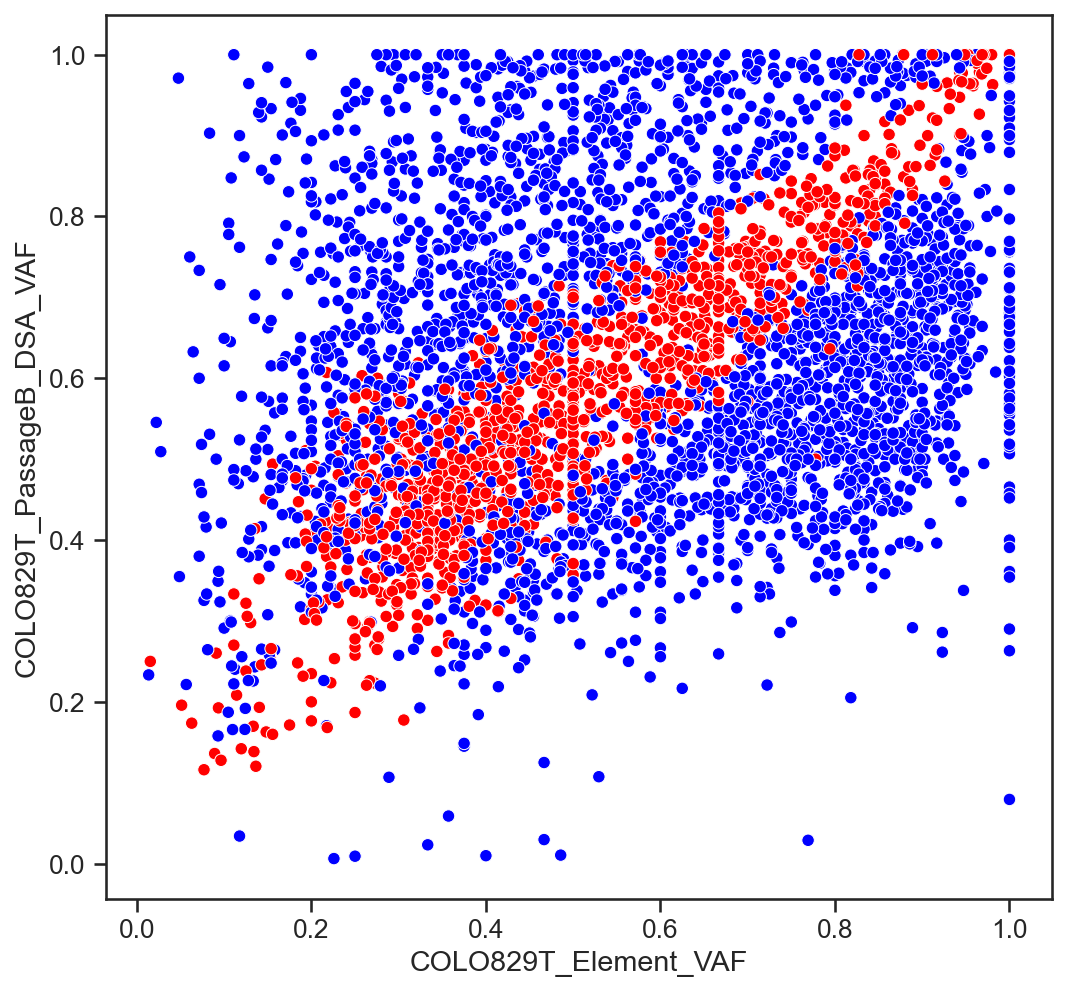

In [58]:
binom_testset['pvalueTB_over_0.05'] = binom_testset['pvalueTB'] >= 0.05

fig, ax = plt.subplots(1, 1, figsize=(7, 6.5), constrained_layout=True)

sns.scatterplot(
    data=binom_testset,
    x="COLO829T_Element_VAF",
    y="COLO829T_PassageB_DSA_VAF",
    hue="pvalueTB_over_0.05",
    palette={True: 'red', False: 'blue'},
    legend=False,
    ax=ax
)


<Axes: xlabel='COLO829T_Element_VAF', ylabel='Count'>

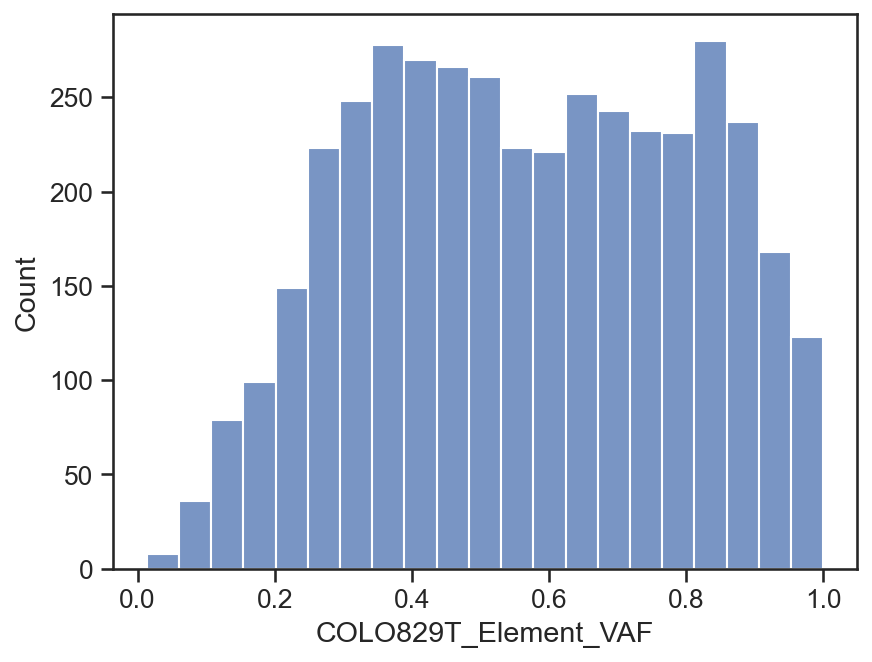

In [59]:
sns.histplot(data=binom_testset, x="COLO829T_Element_VAF")

In [60]:
binom[binom['COLO829T_PassageB_DSA_VAF'] == 0]

,CHROM,POS,REF,ALT,COLO829BL_Element,COLO829T_Element,COLO829BL_Fiber-seq,COLO829T_PassageB_DSA,COLO829T_PassageA_DSA,INDELid,pvalueTB,pvalueTA,COLO829T_Element_VAF,COLO829T_PassageB_DSA_VAF,COLO829T_PassageA_DSA_VAF
272,haplotype1-0000003,126966681,TTTTC,T,"0,63,165:21,0","181,0,60:13,7","60,255,141:177,0","0,175,29:58,0","0,48,16:16,0",haplotype1-0000003_126966681_TTTTC_T,2.033664e-11,1.219782e-03,0.350000,0.0,0.000000
731,haplotype1-0000010,39510823,T,TAC,"0,89,134:54,2","255,0,18:24,28","58,255,107:182,0","255,255,255:123,0","202,255,255:43,0",haplotype1-0000010_39510823_T_TAC,4.367836e-40,1.738173e-14,0.538462,0.0,0.000000
817,haplotype1-0000010,160253872,GAGAA,G,"0,51,154:17,0","117,0,12:9,3","117,255,215:170,0","0,160,44:105,0","0,58,18:54,1",haplotype1-0000010_160253872_GAGAA_G,1.090541e-13,5.329152e-06,0.250000,0.0,0.018182
851,haplotype1-0000011,27084970,AAAG,A,"0,42,212:14,0","87,0,12:9,3","108,255,171:131,0","0,255,40:93,0","0,123,41:41,0",haplotype1-0000011_27084970_AAAG_A,5.492251e-12,1.273805e-05,0.250000,0.0,0.000000
989,haplotype1-0000011,186453984,C,CTG,"0,181,174:60,0","255,0,20:16,13","26,255,63:154,0","255,255,255:78,0","210,255,255:38,0",haplotype1-0000011_186453984_C_CTG,9.412217e-21,2.171018e-10,0.448276,0.0,0.000000
1587,haplotype1-0000017,62927225,A,AGT,"0,84,144:28,0","255,0,12:24,27","36,255,75:101,0","255,255,255:119,0","255,255,255:62,0",haplotype1-0000017_62927225_A_AGT,1.107355e-39,5.055290e-21,0.529412,0.0,0.000000
1962,haplotype1-0000022,30193526,T,TAC,"0,175,204:58,0","255,0,39:31,20","96,255,125:156,0","255,255,255:80,0","255,255,255:40,1",haplotype1-0000022_30193526_T_TAC,9.381140e-18,4.937069e-08,0.392157,0.0,0.024390
2010,haplotype1-0000023,13123588,G,GGT,"0,141,161:47,0","106,0,13:22,7","74,255,112:170,0","255,255,255:78,0","216,237,235:19,0",haplotype1-0000023_13123588_G_GGT,6.958014e-10,1.210047e-02,0.241379,0.0,0.000000
2275,haplotype1-0000026,144721162,A,AAC,"0,154,172:51,0","255,12,0:11,23","54,255,98:134,0","255,255,255:67,0","241,255,255:39,0",haplotype1-0000026_144721162_A_AAC,1.459562e-33,7.702593e-20,0.676471,0.0,0.000000
2946,haplotype2-0000055,8074801,GAGGA,G,"0,45,123:15,0","160,0,7:6,4","58,255,112:181,0","0,105,1:36,0","0,21,1:7,0",haplotype2-0000055_8074801_GAGGA_G,1.184342e-08,4.683520e-02,0.400000,0.0,0.000000


<Axes: xlabel='pvalueTB', ylabel='Count'>

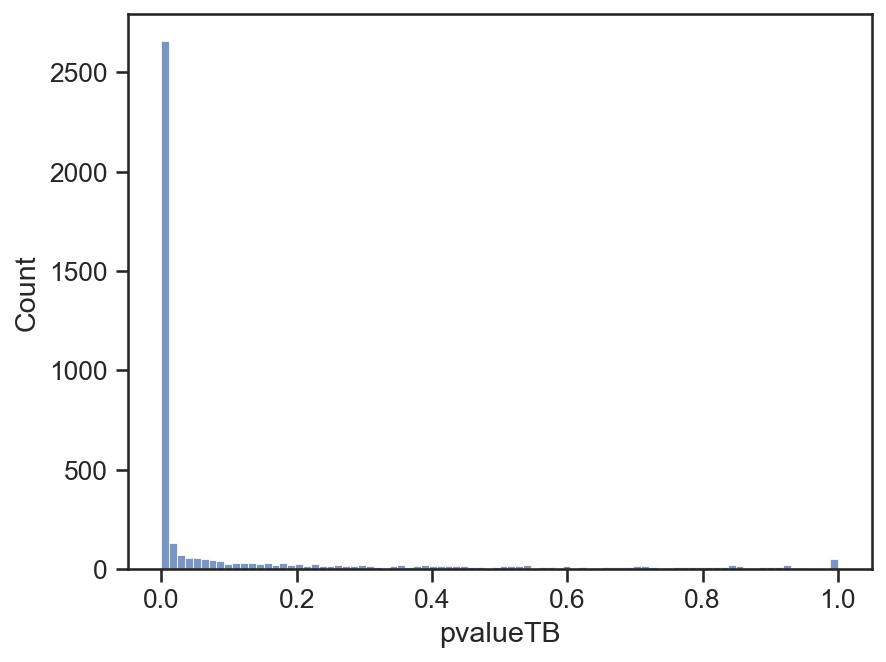

In [61]:
sns.histplot(data=binom, x="pvalueTB")

In [62]:
binom

,CHROM,POS,REF,ALT,COLO829BL_Element,COLO829T_Element,COLO829BL_Fiber-seq,COLO829T_PassageB_DSA,COLO829T_PassageA_DSA,INDELid,pvalueTB,pvalueTA,COLO829T_Element_VAF,COLO829T_PassageB_DSA_VAF,COLO829T_PassageA_DSA_VAF
0,haplotype1-0000001,4708702,C,CGT,"0,181,187:60,0","255,0,114:22,17","6,219,64:162,7","255,0,84:85,42","245,0,93:35,20",haplotype1-0000001_4708702_C_CGT,4.206343e-03,1.765774e-01,0.435897,0.330709,0.363636
1,haplotype1-0000001,6230255,AT,A,"0,184,173:61,0","228,0,81:36,32","0,125,87:145,26","164,255,0:14,123","157,92,0:9,43",haplotype1-0000001_6230255_AT_A,1.839754e-18,3.679643e-05,0.470588,0.897810,0.826923
2,haplotype1-0000001,7439493,GA,G,"0,166,172:55,0","227,0,71:22,34","0,169,96:151,23","118,0,77:57,68","109,0,74:28,24",haplotype1-0000001_7439493_GA_G,8.074833e-03,4.858693e-03,0.607143,0.544000,0.461538
3,haplotype1-0000001,8232382,A,AACAC,"255,255,255:59,0","255,0,16:14,24","255,255,255:154,5","255,191,157:38,58","255,113,96:15,31",haplotype1-0000001_8232382_A_AACAC,4.560990e-01,7.590626e-01,0.631579,0.604167,0.673913
4,haplotype1-0000001,8316016,CA,C,"0,157,152:52,0","169,0,78:28,19","24,71,81:135,31","177,196,39:33,94","152,63,0:8,34",haplotype1-0000001_8316016_CA_C,2.773314e-07,1.387976e-04,0.404255,0.740157,0.809524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4137,haplotype2-0000136,249755,TG,T,"0,144,200:48,0","175,0,115:22,16","0,255,157:247,0","88,72,0:205,73","29,46,0:73,15",haplotype2-0000136_249755_TG_T,4.981189e-08,7.050698e-07,0.421053,0.262590,0.170455
4138,haplotype2-0000137,231988,AGAATG,A,"22,0,87:74,8","29,0,112:94,11","6,182,0:332,52","45,70,0:278,64","75,0,44:77,18",haplotype2-0000137_231988_AGAATG_A,2.019249e-02,1.865248e-01,0.104762,0.187135,0.189474
4139,haplotype2-0000137,270973,A,AAATGG,"0,48,142:93,10","34,0,119:103,14","5,123,0:298,38","71,62,0:290,48","108,0,111:67,14",haplotype2-0000137_270973_A_AAATGG,6.911652e-01,3.281723e-01,0.119658,0.142012,0.172840
4140,haplotype2-0000137,498585,AAATGGAATGG,A,"0,178,255:59,0","225,0,207:55,18","0,196,255:68,0","255,31,0:23,55","255,13,0:3,12",haplotype2-0000137_498585_AAATGGAATGG_A,2.133330e-17,1.060722e-05,0.246575,0.705128,0.800000


In [63]:
c = 0
for i in ultraconservative:
    if i not in merged_ultraconservative_vcf['INDELid'].values:
        c += 1
        print(i)
print(c)

haplotype1-0000011_130327163_TTTTC_T
haplotype2-0000069_871484_CATTAA_C
haplotype2-0000075_1622653_CGGAAT_C
haplotype1-0000028_559951_GAATGGAATGA_G
haplotype2-0000060_44987024_TTTTC_T
haplotype1-0000012_45816292_TTTTC_T
haplotype1-0000024_23496129_G_GGAAA
haplotype2-0000069_150833_GCATTC_G
haplotype2-0000137_346575_CAATGG_C
haplotype1-0000001_82052159_T_TTTG
haplotype2-0000048_81045046_C_CTTCT
haplotype2-0000079_99076195_T_TTA
haplotype2-0000060_154511948_AAAAG_A
haplotype2-0000058_64467062_CTTCT_C
haplotype1-0000010_124024322_GAAGA_G
haplotype1-0000005_10517123_GAAGA_G
haplotype1-0000013_142047411_T_TTTCC
haplotype1-0000003_18420236_GA_G
haplotype1-0000024_52492137_GAAGA_G
haplotype1-0000001_80589968_C_CCAA
haplotype1-0000012_79781897_T_TTTTC
haplotype2-0000069_1928124_G_GATTCC
22


In [ ]:
"/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.8.0/03.ID/MERGED_COLO829T_PassageB_DSA.deepvariant.PASS.indel.annot.ultraconservative.mpileup.indel.reheader.vcf.gz"

## hg38-based analysis (Sanity check)
### To see if indels around homopolymers are also enriched

In [64]:
"""
dir_element_hg38="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Element/VariantCalls_DeepVariant_1.6.1"

colobl_element_hg38_indels_pass = read_vcf(f"{dir_element_hg38}/COLO829BL_Element_hg38/deepvariant/COLO829BL_Element_hg38.deepvariant.split.indel.PASS.vcf.gz")
colotb_element_hg38_indels_pass = read_vcf(f"{dir_element_hg38}/COLO829T_Element_hg38/deepvariant/COLO829T_Element_hg38.deepvariant.split.indel.PASS.vcf.gz")

colobl_element_hg38_indels_pass['INDELid'] = colobl_element_hg38_indels_pass[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
colotb_element_hg38_indels_pass['INDELid'] = colotb_element_hg38_indels_pass[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
"""

'\ndir_element_hg38="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Element/VariantCalls_DeepVariant_1.6.1"\n\ncolobl_element_hg38_indels_pass = read_vcf(f"{dir_element_hg38}/COLO829BL_Element_hg38/deepvariant/COLO829BL_Element_hg38.deepvariant.split.indel.PASS.vcf.gz")\ncolotb_element_hg38_indels_pass = read_vcf(f"{dir_element_hg38}/COLO829T_Element_hg38/deepvariant/COLO829T_Element_hg38.deepvariant.split.indel.PASS.vcf.gz")\n\ncolobl_element_hg38_indels_pass[\'INDELid\'] = colobl_element_hg38_indels_pass[[\'CHROM\', \'POS\', \'REF\', \'ALT\']].astype(str).apply(\'_\'.join, axis=1)\ncolotb_element_hg38_indels_pass[\'INDELid\'] = colotb_element_hg38_indels_pass[[\'CHROM\', \'POS\', \'REF\', \'ALT\']].astype(str).apply(\'_\'.join, axis=1)\n'

In [65]:
"""
colobl_element_hg38_indels_pass.to_csv(f"{dir_element_hg38}/03.ID/COLO829BL_Element_hg38.tsv", sep="\t")
colotb_element_hg38_indels_pass.to_csv(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38.tsv", sep="\t")

colobl_element_hg38_indels_pass_set: set[str] = set(colobl_element_hg38_indels_pass['INDELid'].values)
colotb_element_hg38_indels_pass_set: set[str] = set(colotb_element_hg38_indels_pass['INDELid'].values)

elementonly_hg38 = (colotb_element_hg38_indels_pass_set - colobl_element_hg38_indels_pass_set)
colotb_element_hg38_indels_pass_elementonly = colotb_element_hg38_indels_pass[colotb_element_hg38_indels_pass['INDELid'].isin(elementonly_hg38)]
"""

'\ncolobl_element_hg38_indels_pass.to_csv(f"{dir_element_hg38}/03.ID/COLO829BL_Element_hg38.tsv", sep="\t")\ncolotb_element_hg38_indels_pass.to_csv(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38.tsv", sep="\t")\n\ncolobl_element_hg38_indels_pass_set: set[str] = set(colobl_element_hg38_indels_pass[\'INDELid\'].values)\ncolotb_element_hg38_indels_pass_set: set[str] = set(colotb_element_hg38_indels_pass[\'INDELid\'].values)\n\nelementonly_hg38 = (colotb_element_hg38_indels_pass_set - colobl_element_hg38_indels_pass_set)\ncolotb_element_hg38_indels_pass_elementonly = colotb_element_hg38_indels_pass[colotb_element_hg38_indels_pass[\'INDELid\'].isin(elementonly_hg38)]\n'

In [66]:
"""
colotb_element_hg38_indels_pass_elementonly.to_csv(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly.tsv", sep="\t")
colotb_element_hg38_indels_pass_elementonly_id83_dict = id83_generator(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly.tsv", f"{dir_element}/03.ID/COLO829T_Element_hg38_elementonly_ID83.tsv")
pd.DataFrame(colotb_element_hg38_indels_pass_elementonly_id83_dict.items(), columns=['MutationType', 'COLO829TB']).to_csv(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_ID83_SigProfiler_Input.tsv", sep='\t', index=False)

sigPlt.plotID(matrix_path=f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_ID83_SigProfiler_Input.tsv", 
              output_path=f"{dir_element_hg38}/03.ID", 
              project="COLO829T_Element_hg38_elementonly", 
              plot_type="83", 
              savefig_format="pdf",
              percentage=False)

sigPlt.plotID(matrix_path=f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_ID83_SigProfiler_Input.tsv", 
              output_path=f"{dir_element_hg38}/03.ID", 
              project="COLO829T_Element_hg38_elementonly_Percentage", 
              plot_type="83", 
              savefig_format="pdf",
              percentage=True)

Analyze.cosmic_fit(
    f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_ID83_SigProfiler_Input.tsv", 
    f"{dir_element_hg38}/03.ID", 
    input_type="matrix", 
    context_type="83", 
    collapse_to_SBS96=False, 
    cosmic_version=3.4, 
    exome=False,
    genome_build="GRCh38", 
    signature_database=None,
    exclude_signature_subgroups=None, 
    export_probabilities=True,
    export_probabilities_per_mutation=False, 
    make_plots=True,
    sample_reconstruction_plots="pdf", 
    verbose=False)
"""

'\ncolotb_element_hg38_indels_pass_elementonly.to_csv(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly.tsv", sep="\t")\ncolotb_element_hg38_indels_pass_elementonly_id83_dict = id83_generator(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly.tsv", f"{dir_element}/03.ID/COLO829T_Element_hg38_elementonly_ID83.tsv")\npd.DataFrame(colotb_element_hg38_indels_pass_elementonly_id83_dict.items(), columns=[\'MutationType\', \'COLO829TB\']).to_csv(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_ID83_SigProfiler_Input.tsv", sep=\'\t\', index=False)\n\nsigPlt.plotID(matrix_path=f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_ID83_SigProfiler_Input.tsv", \n              output_path=f"{dir_element_hg38}/03.ID", \n              project="COLO829T_Element_hg38_elementonly", \n              plot_type="83", \n              savefig_format="pdf",\n              percentage=False)\n\nsigPlt.plotID(matrix_path=f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_ele

### Filtered-out (by DP or AD and by excluding indels in SMaHT Extreme Regions)

In [67]:
"""
df_hg38_filter = pd.concat([colotb_element_hg38_indels_pass_elementonly['INDELid'] , vcf_format_getter(colotb_element_hg38_indels_pass_elementonly, 'AD'), vcf_format_getter(colotb_element_hg38_indels_pass_elementonly, 'DP')], axis=1)
df_hg38_filter.columns = ['INDELid', 'AD', 'DP']

colotb_element_hg38_extreme = pd.read_table(f"{dir_element_hg38}/COLO829T_Element_hg38/deepvariant/COLO829T_Element_hg38.deepvariant.split.indel.PASS.extreme", header=None, sep="\t")
colotb_element_hg38_extreme.columns = ["INDELid"]

df_hg38_filter['Extreme'] = df_hg38_filter['INDELid'].isin(colotb_element_hg38_extreme['INDELid'])

df_hg38_filter = df_hg38_filter[(df_hg38_filter['AD'] >= 5) & (df_hg38_filter['AD'] >= 30) & (df_hg38_filter['Extreme'] == False)]

colotb_element_hg38_indels_pass_elementonly_filter = colotb_element_hg38_indels_pass_elementonly[colotb_element_hg38_indels_pass_elementonly['INDELid'].isin(df_hg38_filter['INDELid'])]
colotb_element_hg38_indels_pass_elementonly_filter
"""

'\ndf_hg38_filter = pd.concat([colotb_element_hg38_indels_pass_elementonly[\'INDELid\'] , vcf_format_getter(colotb_element_hg38_indels_pass_elementonly, \'AD\'), vcf_format_getter(colotb_element_hg38_indels_pass_elementonly, \'DP\')], axis=1)\ndf_hg38_filter.columns = [\'INDELid\', \'AD\', \'DP\']\n\ncolotb_element_hg38_extreme = pd.read_table(f"{dir_element_hg38}/COLO829T_Element_hg38/deepvariant/COLO829T_Element_hg38.deepvariant.split.indel.PASS.extreme", header=None, sep="\t")\ncolotb_element_hg38_extreme.columns = ["INDELid"]\n\ndf_hg38_filter[\'Extreme\'] = df_hg38_filter[\'INDELid\'].isin(colotb_element_hg38_extreme[\'INDELid\'])\n\ndf_hg38_filter = df_hg38_filter[(df_hg38_filter[\'AD\'] >= 5) & (df_hg38_filter[\'AD\'] >= 30) & (df_hg38_filter[\'Extreme\'] == False)]\n\ncolotb_element_hg38_indels_pass_elementonly_filter = colotb_element_hg38_indels_pass_elementonly[colotb_element_hg38_indels_pass_elementonly[\'INDELid\'].isin(df_hg38_filter[\'INDELid\'])]\ncolotb_element_hg38_ind

In [68]:
"""
colotb_element_hg38_indels_pass_elementonly_filter.to_csv(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_filter.tsv", sep="\t")
colotb_element_hg38_indels_pass_elementonly_filter_id83_dict = id83_generator(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_filter.tsv", f"{dir_element}/03.ID/COLO829T_Element_hg38_elementonly_filter_ID83.tsv")
pd.DataFrame(colotb_element_hg38_indels_pass_elementonly_filter_id83_dict.items(), columns=['MutationType', 'COLO829TB']).to_csv(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_filter_ID83_SigProfiler_Input.tsv", sep='\t', index=False)

import sigProfilerPlotting as sigPlt
from SigProfilerAssignment import Analyzer as Analyze

sigPlt.plotID(matrix_path=f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_filter_ID83_SigProfiler_Input.tsv", 
              output_path=f"{dir_element_hg38}/03.ID", 
              project="COLO829T_Element_hg38_elementonly_filter", 
              plot_type="83", 
              savefig_format="pdf",
              percentage=False)

sigPlt.plotID(matrix_path=f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_filter_ID83_SigProfiler_Input.tsv", 
              output_path=f"{dir_element_hg38}/03.ID", 
              project="COLO829T_Element_hg38_elementonly_filter_Percentage", 
              plot_type="83", 
              savefig_format="pdf",
              percentage=True)

Analyze.cosmic_fit(
    f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_filter_ID83_SigProfiler_Input.tsv", 
    f"{dir_element_hg38}/03.ID", 
    input_type="matrix", 
    context_type="83", 
    collapse_to_SBS96=False, 
    cosmic_version=3.4, 
    exome=False,
    genome_build="GRCh38", 
    signature_database=None,
    exclude_signature_subgroups=None, 
    export_probabilities=True,
    export_probabilities_per_mutation=False, 
    make_plots=True,
    sample_reconstruction_plots="pdf", 
    verbose=False)
"""

'\ncolotb_element_hg38_indels_pass_elementonly_filter.to_csv(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_filter.tsv", sep="\t")\ncolotb_element_hg38_indels_pass_elementonly_filter_id83_dict = id83_generator(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_filter.tsv", f"{dir_element}/03.ID/COLO829T_Element_hg38_elementonly_filter_ID83.tsv")\npd.DataFrame(colotb_element_hg38_indels_pass_elementonly_filter_id83_dict.items(), columns=[\'MutationType\', \'COLO829TB\']).to_csv(f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_filter_ID83_SigProfiler_Input.tsv", sep=\'\t\', index=False)\n\nimport sigProfilerPlotting as sigPlt\nfrom SigProfilerAssignment import Analyzer as Analyze\n\nsigPlt.plotID(matrix_path=f"{dir_element_hg38}/03.ID/COLO829T_Element_hg38_elementonly_filter_ID83_SigProfiler_Input.tsv", \n              output_path=f"{dir_element_hg38}/03.ID", \n              project="COLO829T_Element_hg38_elementonly_filter", \n              plot_type=

In [69]:
#fasta = Fasta("/mmfs1/gscratch/stergachislab/assemblies/DSA_COLO829BL_v3.0.0.fasta")
#fasta["haplotype1-0000001"][69008:69010].seq

In [70]:
"""
import pyranges as pr
pr.read_bed("/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.6.1/FIREs/01.DSA/FIRE_merged_COLO829BL_and_TB.FlaggerHap.bed.gz", as_df=False, nrows=5)
"""

'\nimport pyranges as pr\npr.read_bed("/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.6.1/FIREs/01.DSA/FIRE_merged_COLO829BL_and_TB.FlaggerHap.bed.gz", as_df=False, nrows=5)\n'